In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cse-251-b-2025/train.npz
/kaggle/input/cse-251-b-2025/test_input.npz


In [2]:
# download the dataset to your folder or use it on kaggle notebook directly

# train_file = np.load('/your_folder/cse-251-b-2025/train.npz')
train_file = np.load('/kaggle/input/cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
# test_file = np.load('/your_folder/test_input.npz')
test_file = np.load('/kaggle/input/cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


In [3]:
import numpy as np

def ego_centric_normalize(data):
    """
    Args:
        data: np.ndarray of shape (N, 50, 110, 6)
    
    Returns:
        normalized_data: np.ndarray of same shape, centered so ego starts at (0, 0)
    """
    # Extract ego agent's position at t=0
    ego_start_pos = data[:, 0, 0, :2]  # shape (N, 2)
    
    # Subtract ego position from all agent positions across all time steps
    centered_positions = data[..., :2] - ego_start_pos[:, None, None, :]  # shape (N, 50, 110, 2)
    
    # Copy rest of data as-is
    normalized_data = np.copy(data)
    normalized_data[..., :2] = centered_positions  # update x, y
    
    return ego_start_pos, normalized_data

In [4]:
ego_train_start_pos, train_data = ego_centric_normalize(train_data)
ego_start_pos, test_data = ego_centric_normalize(test_data)

In [5]:
train_data = train_data[..., :5]
test_data = test_data[..., :5]
print("train_data's shape", train_data.shape)
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 5)
test_data's shape (2100, 50, 50, 5)


In [6]:
# Split x and y for train data.

# reserve last 500 for validation
train_amt = 9500

# for now, let us only care about argo vehicle information
train_x, train_y = train_data[:train_amt, :, :50, :], train_data[:train_amt, 0, 50:, :2]

print(train_x.shape, train_y.shape)

(9500, 50, 50, 5) (9500, 60, 2)


In [7]:
val_x, val_y = train_data[train_amt:, :, :50, :], train_data[train_amt:, 0, 50:, :2]

print(val_x.shape, val_y.shape)

(500, 50, 50, 5) (500, 60, 2)


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR

In [9]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.mlp(x)
        return x.view(x.size(0), 60, 2)

In [10]:
input_features = 50 * 50 * 5  # = 5000
output_features = 60 * 2

mlp_model = MLP(input_features, output_features)

# Define loss function and optimizer
criterion = nn.MSELoss()  # For regression task

optimizer = optim.AdamW(mlp_model.parameters(), lr=0.0001, weight_decay=1e-4)

scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)

In [11]:
import torch
import torch.nn as nn

class SimpleTrajectoryPredictionCNN(nn.Module):
    def __init__(self, input_channels, num_agents=50, seq_len=50, hidden_size=64, dropout=0.3):
        super(SimpleTrajectoryPredictionCNN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(num_agents, hidden_size, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0)),
            nn.ReLU(),
            nn.Conv2d(hidden_size, hidden_size, kernel_size=(5, 1), stride=(2, 1), padding=(2, 0)),
            nn.ReLU()
        )

        self.flatten = nn.Flatten()  # shape: (B, hidden_size * new_seq_len * input_channels)

        self.fc = nn.Sequential(
            nn.Linear(hidden_size * ((seq_len // 4) + 1) * input_channels, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 2 * 60)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x.view(x.size(0), 60, 2)  # (B, 60, 2)


In [12]:
simple_cnn_model = SimpleTrajectoryPredictionCNN(train_data.shape[3])

# Define loss function and optimizer
simple_cnn_criterion = nn.MSELoss()  # For regression task

simple_cnn_optimizer = optim.AdamW(simple_cnn_model.parameters(), lr=0.0001, weight_decay=1e-4)

simple_cnn_scheduler = CosineAnnealingLR(simple_cnn_optimizer, T_max=200, eta_min=1e-6)

In [13]:
import torch
import torch.nn as nn

class TrajectoryPredictionCNN(nn.Module):
    def __init__(self, input_channels, num_agents=50, seq_len=50, hidden_size=128, dropout=0.3):
        super(TrajectoryPredictionCNN, self).__init__()
        
        # Stage 1: Compress seq_len 50 → 25
        self.conv1 = nn.Conv2d(
            in_channels=num_agents, 
            out_channels=hidden_size, 
            kernel_size=(5, 1),      
            stride=(2, 1),
            padding=(2,0)
        )
        self.bn_conv1 = nn.BatchNorm2d(hidden_size)
        
        # Stage 2: Compress seq_len 25 → 12
        self.conv2_downsample = nn.Conv2d(
            in_channels=hidden_size, 
            out_channels=hidden_size, 
            kernel_size=(5, 1), 
            stride=(2, 1),
            padding=(1,0)
        )
        self.bn_conv2_ds = nn.BatchNorm2d(hidden_size)
        
        self.conv3_downsample = nn.Conv2d(
            in_channels=hidden_size, 
            out_channels=hidden_size, 
            kernel_size=(5, 1),     # Reduce from 12 → 6
            stride=(2, 1),          
            padding=(2,0)
        )
        self.bn_conv3_ds = nn.BatchNorm2d(hidden_size)

        self.conv4_downsample = nn.Conv2d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=(6, 1),
            stride=(1, 1)
        )
        self.bn_conv4_ds = nn.BatchNorm2d(hidden_size)

        self.conv2 = nn.Conv2d(
            in_channels=hidden_size, 
            out_channels=hidden_size, 
            kernel_size=(1, 1)       
        )
        self.bn_conv2 = nn.BatchNorm2d(hidden_size)
        
        self.conv_to_fc = nn.Linear(hidden_size * input_channels, hidden_size)
        self.bn_conv_to_fc = nn.BatchNorm1d(hidden_size)
        
        self.fc1 = nn.Linear(hidden_size, 2 * hidden_size)
        self.bn1 = nn.BatchNorm1d(2 * hidden_size)
        
        self.fc2 = nn.Linear(2 * hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        
        self.fc3 = nn.Linear(hidden_size, 2 * 60)
        self.dropout = nn.Dropout(dropout)
        
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Input: (batch_size, num_agents, seq_len=50, input_channels)
        
        # Stage 1: seq_len 50 → 25
        x = self.conv1(x)           # (B, hidden_size, 25, input_channels)
        x = self.bn_conv1(x)
        x = torch.relu(x)
        
        # Stage 2: seq_len 25 → 12
        x = self.conv2_downsample(x) # (B, hidden_size, 12, input_channels)
        x = self.bn_conv2_ds(x)
        x = torch.relu(x)
        
        x = self.conv3_downsample(x)  # (B, hidden_size, 6, input_channels)
        x = self.bn_conv3_ds(x)
        x = torch.relu(x)
        
        # Stage 4: seq_len 6 → 1
        x = self.conv4_downsample(x)  # (B, hidden_size, 1, input_channels)
        residual = x
        x = self.bn_conv4_ds(x)
        x = torch.relu(x)
        
        x = self.conv2(x)           # (B, hidden_size, 1, input_channels)
        x = self.bn_conv2(x)
        x += residual
        x = torch.relu(x)

        x = x.squeeze(2)            # (B, hidden_size, input_channels)
        x = x.reshape(x.size(0), -1) # (B, hidden_size * input_channels)
        
        # Continue with original FC layers
        x = self.conv_to_fc(x)
        residual = x
        x = self.bn_conv_to_fc(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        out = self.fc1(x)
        out = self.bn1(out)
        out = torch.relu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.bn2(out)
        out += residual
        out = torch.relu(out)
        out = self.fc3(out)
        
        return out.view(out.size(0), 60, 2)  # (B, 60, 2)

In [14]:
# Create the model
deep_cnn_model = TrajectoryPredictionCNN(train_data.shape[3])

# Define loss function and optimizer
deep_cnn_criterion = nn.MSELoss()  # For regression task

deep_cnn_optimizer = optim.AdamW(deep_cnn_model.parameters(), lr=0.0005, weight_decay=1e-4)

deep_cnn_scheduler = CosineAnnealingLR(deep_cnn_optimizer, T_max=450, eta_min=1e-6)

In [15]:
from torch.utils.data import DataLoader, TensorDataset
import torch
from tqdm import tqdm
import torch.nn as nn

def train_model(model, optimizer, criterion, scheduler, x_train, y_train, x_val, y_val,
                batch_size=64, epochs=30, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    
    # Move model to device
    model = model.to(device)
    
    # Convert numpy arrays to PyTorch tensors and move them to the device
    X_train_tensor = torch.FloatTensor(x_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_val_tensor = torch.FloatTensor(x_val)
    y_val_tensor = torch.FloatTensor(y_val)
    
    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Create MAE loss function for evaluation
    mae_criterion = nn.L1Loss()
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_mae = 0.0
        
        for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            assert outputs.shape == batch_y.shape
            
            # Compute loss
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            
            # Compute MAE for training set
            mae = mae_criterion(outputs, batch_y).item()
            running_mae += mae
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                outputs = model(batch_X)
                assert outputs.shape == batch_y.shape
                
                # Compute validation loss
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                
                # Compute validation MAE
                mae = mae_criterion(outputs, batch_y).item()
                val_mae += mae
        
        scheduler.step()
        
        # Calculate average metrics
        avg_train_loss = running_loss / len(train_loader)
        avg_train_mae = running_mae / len(train_loader)
        
        avg_val_loss = val_loss / (1 if len(val_loader) == 0 else len(val_loader))
        avg_val_mae = val_mae / (1 if len(val_loader) == 0 else len(val_loader))
        
        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train MAE: {avg_train_mae:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}, Validation MAE: {avg_val_mae:.4f}')
    
    return model

In [16]:
mlp_model = train_model(mlp_model, optimizer, criterion, scheduler, train_x, train_y, val_x, val_y, 64, 100)

Epoch 1/100: 100%|██████████| 149/149 [00:02<00:00, 56.75it/s]


Epoch 1, Train Loss: 1730.8584, Train MAE: 27.3382, Validation Loss: 1604.3280, Validation MAE: 25.8582


Epoch 2/100: 100%|██████████| 149/149 [00:01<00:00, 102.63it/s]


Epoch 2, Train Loss: 1563.1654, Train MAE: 25.4206, Validation Loss: 1604.3253, Validation MAE: 25.8583


Epoch 3/100: 100%|██████████| 149/149 [00:01<00:00, 99.07it/s] 


Epoch 3, Train Loss: 1561.0647, Train MAE: 25.3720, Validation Loss: 1604.3195, Validation MAE: 25.8585


Epoch 4/100: 100%|██████████| 149/149 [00:01<00:00, 101.28it/s]


Epoch 4, Train Loss: 1560.7413, Train MAE: 25.3617, Validation Loss: 1604.3171, Validation MAE: 25.8586


Epoch 5/100: 100%|██████████| 149/149 [00:01<00:00, 102.79it/s]


Epoch 5, Train Loss: 1562.6491, Train MAE: 25.3842, Validation Loss: 1604.3145, Validation MAE: 25.8586


Epoch 6/100: 100%|██████████| 149/149 [00:01<00:00, 102.24it/s]


Epoch 6, Train Loss: 1565.7517, Train MAE: 25.4156, Validation Loss: 1604.3125, Validation MAE: 25.8587


Epoch 7/100: 100%|██████████| 149/149 [00:01<00:00, 98.18it/s]


Epoch 7, Train Loss: 1557.3059, Train MAE: 25.3270, Validation Loss: 1604.3100, Validation MAE: 25.8588


Epoch 8/100: 100%|██████████| 149/149 [00:01<00:00, 101.35it/s]


Epoch 8, Train Loss: 1561.5657, Train MAE: 25.3733, Validation Loss: 1604.3076, Validation MAE: 25.8589


Epoch 9/100: 100%|██████████| 149/149 [00:01<00:00, 101.15it/s]


Epoch 9, Train Loss: 1561.3691, Train MAE: 25.3720, Validation Loss: 1604.3053, Validation MAE: 25.8590


Epoch 10/100: 100%|██████████| 149/149 [00:01<00:00, 101.65it/s]


Epoch 10, Train Loss: 1560.7654, Train MAE: 25.3615, Validation Loss: 1604.3024, Validation MAE: 25.8591


Epoch 11/100: 100%|██████████| 149/149 [00:01<00:00, 101.17it/s]


Epoch 11, Train Loss: 1559.2745, Train MAE: 25.3541, Validation Loss: 1604.3002, Validation MAE: 25.8592


Epoch 12/100: 100%|██████████| 149/149 [00:01<00:00, 102.13it/s]


Epoch 12, Train Loss: 1558.5024, Train MAE: 25.3424, Validation Loss: 1604.2983, Validation MAE: 25.8594


Epoch 13/100: 100%|██████████| 149/149 [00:01<00:00, 103.95it/s]


Epoch 13, Train Loss: 1559.7219, Train MAE: 25.3494, Validation Loss: 1604.2964, Validation MAE: 25.8595


Epoch 14/100: 100%|██████████| 149/149 [00:01<00:00, 102.94it/s]


Epoch 14, Train Loss: 1559.3546, Train MAE: 25.3459, Validation Loss: 1604.2946, Validation MAE: 25.8596


Epoch 15/100: 100%|██████████| 149/149 [00:01<00:00, 104.33it/s]


Epoch 15, Train Loss: 1558.3029, Train MAE: 25.3401, Validation Loss: 1604.2928, Validation MAE: 25.8597


Epoch 16/100: 100%|██████████| 149/149 [00:01<00:00, 99.90it/s]


Epoch 16, Train Loss: 1558.3603, Train MAE: 25.3439, Validation Loss: 1604.2905, Validation MAE: 25.8599


Epoch 17/100: 100%|██████████| 149/149 [00:01<00:00, 99.73it/s] 


Epoch 17, Train Loss: 1562.2595, Train MAE: 25.3837, Validation Loss: 1604.1816, Validation MAE: 25.8600


Epoch 18/100: 100%|██████████| 149/149 [00:01<00:00, 101.41it/s]


Epoch 18, Train Loss: 1565.4242, Train MAE: 25.3645, Validation Loss: 1602.4992, Validation MAE: 25.8497


Epoch 19/100: 100%|██████████| 149/149 [00:01<00:00, 101.33it/s]


Epoch 19, Train Loss: 1621.2551, Train MAE: 25.4149, Validation Loss: 1603.6452, Validation MAE: 25.8797


Epoch 20/100: 100%|██████████| 149/149 [00:01<00:00, 103.00it/s]


Epoch 20, Train Loss: 1557.1511, Train MAE: 25.3087, Validation Loss: 1601.3532, Validation MAE: 25.8415


Epoch 21/100: 100%|██████████| 149/149 [00:01<00:00, 102.85it/s]


Epoch 21, Train Loss: 1555.1086, Train MAE: 25.2958, Validation Loss: 1584.6703, Validation MAE: 25.7075


Epoch 22/100: 100%|██████████| 149/149 [00:01<00:00, 99.95it/s] 


Epoch 22, Train Loss: 1582.9553, Train MAE: 25.3714, Validation Loss: 1645.0727, Validation MAE: 26.0380


Epoch 23/100: 100%|██████████| 149/149 [00:01<00:00, 100.55it/s]


Epoch 23, Train Loss: 1564.3203, Train MAE: 25.3440, Validation Loss: 1584.8381, Validation MAE: 25.7333


Epoch 24/100: 100%|██████████| 149/149 [00:01<00:00, 101.97it/s]


Epoch 24, Train Loss: 1589.2939, Train MAE: 25.3733, Validation Loss: 1561.3449, Validation MAE: 25.6384


Epoch 25/100: 100%|██████████| 149/149 [00:01<00:00, 103.14it/s]


Epoch 25, Train Loss: 1561.2206, Train MAE: 25.3322, Validation Loss: 1577.2346, Validation MAE: 25.6346


Epoch 26/100: 100%|██████████| 149/149 [00:01<00:00, 102.43it/s]


Epoch 26, Train Loss: 1552.1454, Train MAE: 25.2038, Validation Loss: 1564.4252, Validation MAE: 25.6090


Epoch 27/100: 100%|██████████| 149/149 [00:01<00:00, 101.06it/s]


Epoch 27, Train Loss: 1543.0117, Train MAE: 25.1232, Validation Loss: 1592.3797, Validation MAE: 25.7230


Epoch 28/100: 100%|██████████| 149/149 [00:01<00:00, 101.80it/s]


Epoch 28, Train Loss: 1547.9773, Train MAE: 25.0759, Validation Loss: 1565.9254, Validation MAE: 25.5625


Epoch 29/100: 100%|██████████| 149/149 [00:01<00:00, 100.42it/s]


Epoch 29, Train Loss: 1542.4858, Train MAE: 25.0191, Validation Loss: 1559.7821, Validation MAE: 25.4627


Epoch 30/100: 100%|██████████| 149/149 [00:01<00:00, 103.33it/s]


Epoch 30, Train Loss: 1521.6491, Train MAE: 24.9171, Validation Loss: 1546.9903, Validation MAE: 25.2325


Epoch 31/100: 100%|██████████| 149/149 [00:01<00:00, 102.99it/s]


Epoch 31, Train Loss: 1512.5056, Train MAE: 24.8457, Validation Loss: 1540.8170, Validation MAE: 25.2423


Epoch 32/100: 100%|██████████| 149/149 [00:01<00:00, 102.59it/s]


Epoch 32, Train Loss: 1512.6186, Train MAE: 24.7763, Validation Loss: 1528.8946, Validation MAE: 25.1876


Epoch 33/100: 100%|██████████| 149/149 [00:01<00:00, 101.05it/s]


Epoch 33, Train Loss: 1499.1739, Train MAE: 24.6908, Validation Loss: 1521.7740, Validation MAE: 24.9811


Epoch 34/100: 100%|██████████| 149/149 [00:01<00:00, 101.65it/s]


Epoch 34, Train Loss: 1606.5355, Train MAE: 24.7777, Validation Loss: 1503.4253, Validation MAE: 24.9300


Epoch 35/100: 100%|██████████| 149/149 [00:01<00:00, 101.68it/s]


Epoch 35, Train Loss: 1481.1182, Train MAE: 24.4917, Validation Loss: 1456.8663, Validation MAE: 24.8581


Epoch 36/100: 100%|██████████| 149/149 [00:01<00:00, 100.23it/s]


Epoch 36, Train Loss: 1473.6892, Train MAE: 24.3387, Validation Loss: 1495.4928, Validation MAE: 24.7986


Epoch 37/100: 100%|██████████| 149/149 [00:01<00:00, 102.71it/s]


Epoch 37, Train Loss: 1498.9229, Train MAE: 24.3602, Validation Loss: 1488.7282, Validation MAE: 24.7271


Epoch 38/100: 100%|██████████| 149/149 [00:01<00:00, 103.48it/s]


Epoch 38, Train Loss: 1443.8765, Train MAE: 24.0674, Validation Loss: 1410.8693, Validation MAE: 24.0716


Epoch 39/100: 100%|██████████| 149/149 [00:01<00:00, 102.57it/s]


Epoch 39, Train Loss: 1439.5350, Train MAE: 23.9956, Validation Loss: 1405.2234, Validation MAE: 23.9851


Epoch 40/100: 100%|██████████| 149/149 [00:01<00:00, 101.62it/s]


Epoch 40, Train Loss: 1459.4711, Train MAE: 23.9620, Validation Loss: 1437.7699, Validation MAE: 24.3135


Epoch 41/100: 100%|██████████| 149/149 [00:01<00:00, 100.06it/s]


Epoch 41, Train Loss: 1464.1092, Train MAE: 23.7908, Validation Loss: 1361.5519, Validation MAE: 23.5132


Epoch 42/100: 100%|██████████| 149/149 [00:01<00:00, 102.57it/s]


Epoch 42, Train Loss: 1396.4224, Train MAE: 23.5886, Validation Loss: 1338.0614, Validation MAE: 23.4665


Epoch 43/100: 100%|██████████| 149/149 [00:01<00:00, 100.02it/s]


Epoch 43, Train Loss: 1382.6765, Train MAE: 23.3090, Validation Loss: 1302.0194, Validation MAE: 23.2159


Epoch 44/100: 100%|██████████| 149/149 [00:01<00:00, 102.26it/s]


Epoch 44, Train Loss: 1436.1707, Train MAE: 23.1089, Validation Loss: 1285.1865, Validation MAE: 22.8797


Epoch 45/100: 100%|██████████| 149/149 [00:01<00:00, 101.86it/s]


Epoch 45, Train Loss: 1296.1909, Train MAE: 22.6519, Validation Loss: 1148.0735, Validation MAE: 21.6450


Epoch 46/100: 100%|██████████| 149/149 [00:01<00:00, 101.35it/s]


Epoch 46, Train Loss: 1162.4843, Train MAE: 21.7697, Validation Loss: 1173.8055, Validation MAE: 22.0822


Epoch 47/100: 100%|██████████| 149/149 [00:01<00:00, 103.02it/s]


Epoch 47, Train Loss: 1144.6578, Train MAE: 21.0227, Validation Loss: 949.4751, Validation MAE: 20.1851


Epoch 48/100: 100%|██████████| 149/149 [00:01<00:00, 101.49it/s]


Epoch 48, Train Loss: 957.9560, Train MAE: 19.7080, Validation Loss: 775.0003, Validation MAE: 18.3599


Epoch 49/100: 100%|██████████| 149/149 [00:01<00:00, 104.61it/s]


Epoch 49, Train Loss: 838.2906, Train MAE: 18.5959, Validation Loss: 746.4888, Validation MAE: 17.9351


Epoch 50/100: 100%|██████████| 149/149 [00:01<00:00, 101.32it/s]


Epoch 50, Train Loss: 757.3117, Train MAE: 17.4717, Validation Loss: 696.4277, Validation MAE: 17.2332


Epoch 51/100: 100%|██████████| 149/149 [00:01<00:00, 102.52it/s]


Epoch 51, Train Loss: 704.8132, Train MAE: 16.9873, Validation Loss: 676.4416, Validation MAE: 16.3484


Epoch 52/100: 100%|██████████| 149/149 [00:01<00:00, 103.57it/s]


Epoch 52, Train Loss: 654.4079, Train MAE: 16.1527, Validation Loss: 659.5854, Validation MAE: 16.5368


Epoch 53/100: 100%|██████████| 149/149 [00:01<00:00, 102.96it/s]


Epoch 53, Train Loss: 610.2967, Train MAE: 15.6016, Validation Loss: 524.6333, Validation MAE: 14.8033


Epoch 54/100: 100%|██████████| 149/149 [00:01<00:00, 101.87it/s]


Epoch 54, Train Loss: 581.5949, Train MAE: 15.1889, Validation Loss: 523.0681, Validation MAE: 14.6467


Epoch 55/100: 100%|██████████| 149/149 [00:01<00:00, 101.58it/s]


Epoch 55, Train Loss: 527.4168, Train MAE: 14.4805, Validation Loss: 483.1024, Validation MAE: 13.9121


Epoch 56/100: 100%|██████████| 149/149 [00:01<00:00, 102.34it/s]


Epoch 56, Train Loss: 520.2384, Train MAE: 14.3187, Validation Loss: 510.8267, Validation MAE: 14.6658


Epoch 57/100: 100%|██████████| 149/149 [00:01<00:00, 101.59it/s]


Epoch 57, Train Loss: 504.4952, Train MAE: 14.0357, Validation Loss: 488.7669, Validation MAE: 13.9366


Epoch 58/100: 100%|██████████| 149/149 [00:01<00:00, 102.95it/s]


Epoch 58, Train Loss: 507.4564, Train MAE: 13.8786, Validation Loss: 450.6081, Validation MAE: 13.5297


Epoch 59/100: 100%|██████████| 149/149 [00:01<00:00, 101.45it/s]


Epoch 59, Train Loss: 471.4640, Train MAE: 13.4904, Validation Loss: 431.9463, Validation MAE: 13.0905


Epoch 60/100: 100%|██████████| 149/149 [00:01<00:00, 102.65it/s]


Epoch 60, Train Loss: 433.8628, Train MAE: 13.0458, Validation Loss: 399.8670, Validation MAE: 12.9199


Epoch 61/100: 100%|██████████| 149/149 [00:01<00:00, 102.57it/s]


Epoch 61, Train Loss: 444.2994, Train MAE: 13.0871, Validation Loss: 469.8789, Validation MAE: 13.8595


Epoch 62/100: 100%|██████████| 149/149 [00:01<00:00, 102.81it/s]


Epoch 62, Train Loss: 409.9077, Train MAE: 12.5191, Validation Loss: 408.7357, Validation MAE: 13.0723


Epoch 63/100: 100%|██████████| 149/149 [00:01<00:00, 101.87it/s]


Epoch 63, Train Loss: 396.8422, Train MAE: 12.3308, Validation Loss: 404.0140, Validation MAE: 13.2252


Epoch 64/100: 100%|██████████| 149/149 [00:01<00:00, 99.10it/s] 


Epoch 64, Train Loss: 380.7827, Train MAE: 12.2673, Validation Loss: 373.5470, Validation MAE: 12.1989


Epoch 65/100: 100%|██████████| 149/149 [00:01<00:00, 99.68it/s] 


Epoch 65, Train Loss: 372.0437, Train MAE: 11.9756, Validation Loss: 370.7332, Validation MAE: 12.3072


Epoch 66/100: 100%|██████████| 149/149 [00:01<00:00, 101.61it/s]


Epoch 66, Train Loss: 369.4927, Train MAE: 11.7271, Validation Loss: 413.1840, Validation MAE: 13.3276


Epoch 67/100: 100%|██████████| 149/149 [00:01<00:00, 100.15it/s]


Epoch 67, Train Loss: 349.8232, Train MAE: 11.6138, Validation Loss: 404.9628, Validation MAE: 12.9262


Epoch 68/100: 100%|██████████| 149/149 [00:01<00:00, 101.00it/s]


Epoch 68, Train Loss: 343.7267, Train MAE: 11.5073, Validation Loss: 343.9478, Validation MAE: 11.8646


Epoch 69/100: 100%|██████████| 149/149 [00:01<00:00, 103.12it/s]


Epoch 69, Train Loss: 333.0068, Train MAE: 11.2686, Validation Loss: 359.6366, Validation MAE: 12.0788


Epoch 70/100: 100%|██████████| 149/149 [00:01<00:00, 101.73it/s]


Epoch 70, Train Loss: 320.9930, Train MAE: 11.0984, Validation Loss: 352.1217, Validation MAE: 12.0264


Epoch 71/100: 100%|██████████| 149/149 [00:01<00:00, 102.51it/s]


Epoch 71, Train Loss: 312.8935, Train MAE: 10.8993, Validation Loss: 329.9482, Validation MAE: 11.5558


Epoch 72/100: 100%|██████████| 149/149 [00:01<00:00, 99.93it/s] 


Epoch 72, Train Loss: 303.7801, Train MAE: 10.8039, Validation Loss: 314.8300, Validation MAE: 11.3922


Epoch 73/100: 100%|██████████| 149/149 [00:01<00:00, 102.64it/s]


Epoch 73, Train Loss: 300.7765, Train MAE: 10.5876, Validation Loss: 337.5833, Validation MAE: 11.6411


Epoch 74/100: 100%|██████████| 149/149 [00:01<00:00, 101.67it/s]


Epoch 74, Train Loss: 307.1627, Train MAE: 10.7031, Validation Loss: 358.5319, Validation MAE: 12.0690


Epoch 75/100: 100%|██████████| 149/149 [00:01<00:00, 101.24it/s]


Epoch 75, Train Loss: 290.1902, Train MAE: 10.4077, Validation Loss: 329.7666, Validation MAE: 11.5619


Epoch 76/100: 100%|██████████| 149/149 [00:01<00:00, 100.62it/s]


Epoch 76, Train Loss: 289.7091, Train MAE: 10.3211, Validation Loss: 315.2890, Validation MAE: 11.3577


Epoch 77/100: 100%|██████████| 149/149 [00:01<00:00, 102.96it/s]


Epoch 77, Train Loss: 271.1577, Train MAE: 10.0523, Validation Loss: 330.7745, Validation MAE: 11.3909


Epoch 78/100: 100%|██████████| 149/149 [00:01<00:00, 102.02it/s]


Epoch 78, Train Loss: 264.4514, Train MAE: 9.9959, Validation Loss: 307.9360, Validation MAE: 11.1630


Epoch 79/100: 100%|██████████| 149/149 [00:01<00:00, 103.01it/s]


Epoch 79, Train Loss: 275.7273, Train MAE: 9.9272, Validation Loss: 299.7878, Validation MAE: 11.0469


Epoch 80/100: 100%|██████████| 149/149 [00:01<00:00, 102.59it/s]


Epoch 80, Train Loss: 266.5432, Train MAE: 9.9095, Validation Loss: 285.9603, Validation MAE: 10.8980


Epoch 81/100: 100%|██████████| 149/149 [00:01<00:00, 102.59it/s]


Epoch 81, Train Loss: 256.1943, Train MAE: 9.7525, Validation Loss: 300.2612, Validation MAE: 10.8712


Epoch 82/100: 100%|██████████| 149/149 [00:01<00:00, 103.87it/s]


Epoch 82, Train Loss: 256.8590, Train MAE: 9.7103, Validation Loss: 303.7916, Validation MAE: 11.1629


Epoch 83/100: 100%|██████████| 149/149 [00:01<00:00, 99.11it/s]


Epoch 83, Train Loss: 244.9949, Train MAE: 9.5950, Validation Loss: 295.8013, Validation MAE: 10.9853


Epoch 84/100: 100%|██████████| 149/149 [00:01<00:00, 102.24it/s]


Epoch 84, Train Loss: 247.6230, Train MAE: 9.6168, Validation Loss: 287.7983, Validation MAE: 10.7227


Epoch 85/100: 100%|██████████| 149/149 [00:01<00:00, 100.00it/s]


Epoch 85, Train Loss: 234.8533, Train MAE: 9.4778, Validation Loss: 282.7855, Validation MAE: 10.5981


Epoch 86/100: 100%|██████████| 149/149 [00:01<00:00, 98.49it/s] 


Epoch 86, Train Loss: 231.3761, Train MAE: 9.3303, Validation Loss: 275.4225, Validation MAE: 10.6435


Epoch 87/100: 100%|██████████| 149/149 [00:01<00:00, 104.03it/s]


Epoch 87, Train Loss: 222.5284, Train MAE: 9.2326, Validation Loss: 276.1992, Validation MAE: 10.7078


Epoch 88/100: 100%|██████████| 149/149 [00:01<00:00, 102.10it/s]


Epoch 88, Train Loss: 222.3676, Train MAE: 9.1786, Validation Loss: 277.3060, Validation MAE: 10.5648


Epoch 89/100: 100%|██████████| 149/149 [00:01<00:00, 103.32it/s]


Epoch 89, Train Loss: 222.8585, Train MAE: 9.2483, Validation Loss: 281.9879, Validation MAE: 10.6380


Epoch 90/100: 100%|██████████| 149/149 [00:01<00:00, 101.47it/s]


Epoch 90, Train Loss: 215.4445, Train MAE: 9.0621, Validation Loss: 284.0863, Validation MAE: 10.6485


Epoch 91/100: 100%|██████████| 149/149 [00:01<00:00, 102.03it/s]


Epoch 91, Train Loss: 218.4155, Train MAE: 9.0654, Validation Loss: 267.3061, Validation MAE: 10.4329


Epoch 92/100: 100%|██████████| 149/149 [00:01<00:00, 100.23it/s]


Epoch 92, Train Loss: 218.8818, Train MAE: 9.0668, Validation Loss: 269.3453, Validation MAE: 10.5702


Epoch 93/100: 100%|██████████| 149/149 [00:01<00:00, 99.90it/s] 


Epoch 93, Train Loss: 201.3871, Train MAE: 8.8193, Validation Loss: 262.7513, Validation MAE: 10.4742


Epoch 94/100: 100%|██████████| 149/149 [00:01<00:00, 103.92it/s]


Epoch 94, Train Loss: 204.8447, Train MAE: 8.9189, Validation Loss: 267.1436, Validation MAE: 10.4754


Epoch 95/100: 100%|██████████| 149/149 [00:01<00:00, 103.92it/s]


Epoch 95, Train Loss: 201.5943, Train MAE: 8.8224, Validation Loss: 264.8336, Validation MAE: 10.3625


Epoch 96/100: 100%|██████████| 149/149 [00:01<00:00, 101.39it/s]


Epoch 96, Train Loss: 207.3255, Train MAE: 8.8378, Validation Loss: 273.9551, Validation MAE: 10.5912


Epoch 97/100: 100%|██████████| 149/149 [00:01<00:00, 103.43it/s]


Epoch 97, Train Loss: 195.9306, Train MAE: 8.6928, Validation Loss: 269.4525, Validation MAE: 10.5141


Epoch 98/100: 100%|██████████| 149/149 [00:01<00:00, 104.82it/s]


Epoch 98, Train Loss: 195.6893, Train MAE: 8.6936, Validation Loss: 259.5280, Validation MAE: 10.2034


Epoch 99/100: 100%|██████████| 149/149 [00:01<00:00, 102.83it/s]


Epoch 99, Train Loss: 192.8178, Train MAE: 8.6077, Validation Loss: 267.0046, Validation MAE: 10.4603


Epoch 100/100: 100%|██████████| 149/149 [00:01<00:00, 103.10it/s]


Epoch 100, Train Loss: 194.7739, Train MAE: 8.6802, Validation Loss: 261.1365, Validation MAE: 10.4320


In [17]:
simple_cnn_model = train_model(simple_cnn_model, simple_cnn_optimizer, simple_cnn_criterion, simple_cnn_scheduler, train_x, train_y, val_x, val_y, 64, 100)

Epoch 1/100: 100%|██████████| 149/149 [00:01<00:00, 87.43it/s] 


Epoch 1, Train Loss: 1675.4854, Train MAE: 26.2325, Validation Loss: 1604.4147, Validation MAE: 25.8657


Epoch 2/100: 100%|██████████| 149/149 [00:00<00:00, 205.40it/s]


Epoch 2, Train Loss: 1560.6206, Train MAE: 25.3632, Validation Loss: 1604.3738, Validation MAE: 25.8670


Epoch 3/100: 100%|██████████| 149/149 [00:00<00:00, 200.66it/s]


Epoch 3, Train Loss: 1560.2749, Train MAE: 25.3647, Validation Loss: 1604.3124, Validation MAE: 25.8642


Epoch 4/100: 100%|██████████| 149/149 [00:00<00:00, 191.84it/s]


Epoch 4, Train Loss: 1559.8472, Train MAE: 25.3567, Validation Loss: 1604.3116, Validation MAE: 25.8645


Epoch 5/100: 100%|██████████| 149/149 [00:00<00:00, 201.50it/s]


Epoch 5, Train Loss: 1558.8789, Train MAE: 25.3442, Validation Loss: 1604.3102, Validation MAE: 25.8645


Epoch 6/100: 100%|██████████| 149/149 [00:00<00:00, 207.81it/s]


Epoch 6, Train Loss: 1559.6987, Train MAE: 25.3608, Validation Loss: 1604.3067, Validation MAE: 25.8646


Epoch 7/100: 100%|██████████| 149/149 [00:00<00:00, 201.90it/s]


Epoch 7, Train Loss: 1561.2235, Train MAE: 25.3808, Validation Loss: 1604.3041, Validation MAE: 25.8647


Epoch 8/100: 100%|██████████| 149/149 [00:00<00:00, 198.53it/s]


Epoch 8, Train Loss: 1556.9471, Train MAE: 25.3268, Validation Loss: 1604.3013, Validation MAE: 25.8648


Epoch 9/100: 100%|██████████| 149/149 [00:00<00:00, 199.60it/s]


Epoch 9, Train Loss: 1561.6161, Train MAE: 25.3759, Validation Loss: 1604.2984, Validation MAE: 25.8649


Epoch 10/100: 100%|██████████| 149/149 [00:00<00:00, 207.98it/s]


Epoch 10, Train Loss: 1559.1361, Train MAE: 25.3530, Validation Loss: 1604.2958, Validation MAE: 25.8649


Epoch 11/100: 100%|██████████| 149/149 [00:00<00:00, 200.06it/s]


Epoch 11, Train Loss: 1559.8092, Train MAE: 25.3678, Validation Loss: 1604.2927, Validation MAE: 25.8650


Epoch 12/100: 100%|██████████| 149/149 [00:00<00:00, 196.09it/s]


Epoch 12, Train Loss: 1557.6139, Train MAE: 25.3319, Validation Loss: 1604.2900, Validation MAE: 25.8652


Epoch 13/100: 100%|██████████| 149/149 [00:00<00:00, 208.14it/s]


Epoch 13, Train Loss: 1560.7250, Train MAE: 25.3785, Validation Loss: 1604.2875, Validation MAE: 25.8653


Epoch 14/100: 100%|██████████| 149/149 [00:00<00:00, 204.98it/s]


Epoch 14, Train Loss: 1559.9559, Train MAE: 25.3697, Validation Loss: 1604.2850, Validation MAE: 25.8654


Epoch 15/100: 100%|██████████| 149/149 [00:00<00:00, 206.01it/s]


Epoch 15, Train Loss: 1558.4032, Train MAE: 25.3415, Validation Loss: 1604.2821, Validation MAE: 25.8656


Epoch 16/100: 100%|██████████| 149/149 [00:00<00:00, 199.95it/s]


Epoch 16, Train Loss: 1560.5046, Train MAE: 25.3686, Validation Loss: 1604.2797, Validation MAE: 25.8657


Epoch 17/100: 100%|██████████| 149/149 [00:00<00:00, 190.39it/s]


Epoch 17, Train Loss: 1559.3408, Train MAE: 25.3581, Validation Loss: 1604.2771, Validation MAE: 25.8658


Epoch 18/100: 100%|██████████| 149/149 [00:00<00:00, 225.82it/s]


Epoch 18, Train Loss: 1560.3010, Train MAE: 25.3631, Validation Loss: 1604.2753, Validation MAE: 25.8659


Epoch 19/100: 100%|██████████| 149/149 [00:00<00:00, 232.56it/s]


Epoch 19, Train Loss: 1559.0830, Train MAE: 25.3592, Validation Loss: 1604.2726, Validation MAE: 25.8661


Epoch 20/100: 100%|██████████| 149/149 [00:00<00:00, 228.87it/s]


Epoch 20, Train Loss: 1557.7425, Train MAE: 25.3443, Validation Loss: 1604.2697, Validation MAE: 25.8663


Epoch 21/100: 100%|██████████| 149/149 [00:00<00:00, 232.74it/s]


Epoch 21, Train Loss: 1559.9318, Train MAE: 25.3686, Validation Loss: 1604.2679, Validation MAE: 25.8664


Epoch 22/100: 100%|██████████| 149/149 [00:00<00:00, 231.81it/s]


Epoch 22, Train Loss: 1561.8443, Train MAE: 25.3851, Validation Loss: 1604.2655, Validation MAE: 25.8666


Epoch 23/100: 100%|██████████| 149/149 [00:00<00:00, 230.21it/s]


Epoch 23, Train Loss: 1557.7810, Train MAE: 25.3464, Validation Loss: 1604.2630, Validation MAE: 25.8668


Epoch 24/100: 100%|██████████| 149/149 [00:00<00:00, 202.65it/s]


Epoch 24, Train Loss: 1559.8545, Train MAE: 25.3642, Validation Loss: 1604.2606, Validation MAE: 25.8670


Epoch 25/100: 100%|██████████| 149/149 [00:00<00:00, 203.56it/s]


Epoch 25, Train Loss: 1559.4575, Train MAE: 25.3679, Validation Loss: 1604.2581, Validation MAE: 25.8672


Epoch 26/100: 100%|██████████| 149/149 [00:00<00:00, 193.27it/s]


Epoch 26, Train Loss: 1559.8686, Train MAE: 25.3675, Validation Loss: 1604.2557, Validation MAE: 25.8674


Epoch 27/100: 100%|██████████| 149/149 [00:00<00:00, 198.35it/s]


Epoch 27, Train Loss: 1560.0740, Train MAE: 25.3687, Validation Loss: 1604.2360, Validation MAE: 25.8675


Epoch 28/100: 100%|██████████| 149/149 [00:00<00:00, 197.77it/s]


Epoch 28, Train Loss: 1561.1257, Train MAE: 25.3855, Validation Loss: 1604.2511, Validation MAE: 25.8678


Epoch 29/100: 100%|██████████| 149/149 [00:00<00:00, 201.74it/s]


Epoch 29, Train Loss: 1560.0413, Train MAE: 25.3684, Validation Loss: 1604.2032, Validation MAE: 25.8673


Epoch 30/100: 100%|██████████| 149/149 [00:00<00:00, 194.73it/s]


Epoch 30, Train Loss: 1560.2738, Train MAE: 25.4188, Validation Loss: 1599.4841, Validation MAE: 25.9319


Epoch 31/100: 100%|██████████| 149/149 [00:00<00:00, 195.40it/s]


Epoch 31, Train Loss: 1541.9225, Train MAE: 25.3138, Validation Loss: 1548.6104, Validation MAE: 25.5363


Epoch 32/100: 100%|██████████| 149/149 [00:00<00:00, 204.96it/s]


Epoch 32, Train Loss: 1499.7783, Train MAE: 25.1079, Validation Loss: 1495.3100, Validation MAE: 25.3925


Epoch 33/100: 100%|██████████| 149/149 [00:00<00:00, 197.09it/s]


Epoch 33, Train Loss: 1447.7618, Train MAE: 24.7276, Validation Loss: 1425.5022, Validation MAE: 24.7552


Epoch 34/100: 100%|██████████| 149/149 [00:00<00:00, 206.25it/s]


Epoch 34, Train Loss: 1400.7017, Train MAE: 24.4655, Validation Loss: 1358.3400, Validation MAE: 24.1554


Epoch 35/100: 100%|██████████| 149/149 [00:00<00:00, 207.87it/s]


Epoch 35, Train Loss: 1301.7185, Train MAE: 23.5941, Validation Loss: 1111.1133, Validation MAE: 21.5916


Epoch 36/100: 100%|██████████| 149/149 [00:00<00:00, 207.12it/s]


Epoch 36, Train Loss: 1074.4936, Train MAE: 21.1928, Validation Loss: 707.5695, Validation MAE: 17.0669


Epoch 37/100: 100%|██████████| 149/149 [00:00<00:00, 203.18it/s]


Epoch 37, Train Loss: 577.6952, Train MAE: 15.1620, Validation Loss: 137.0524, Validation MAE: 7.5833


Epoch 38/100: 100%|██████████| 149/149 [00:00<00:00, 205.87it/s]


Epoch 38, Train Loss: 269.9928, Train MAE: 10.3642, Validation Loss: 75.2359, Validation MAE: 5.5956


Epoch 39/100: 100%|██████████| 149/149 [00:00<00:00, 208.78it/s]


Epoch 39, Train Loss: 200.6370, Train MAE: 8.9875, Validation Loss: 55.9896, Validation MAE: 4.7807


Epoch 40/100: 100%|██████████| 149/149 [00:00<00:00, 212.33it/s]


Epoch 40, Train Loss: 171.1742, Train MAE: 8.3090, Validation Loss: 49.0073, Validation MAE: 4.4648


Epoch 41/100: 100%|██████████| 149/149 [00:00<00:00, 202.10it/s]


Epoch 41, Train Loss: 157.7907, Train MAE: 7.9932, Validation Loss: 43.3700, Validation MAE: 4.1925


Epoch 42/100: 100%|██████████| 149/149 [00:00<00:00, 213.44it/s]


Epoch 42, Train Loss: 145.4818, Train MAE: 7.7142, Validation Loss: 41.3641, Validation MAE: 4.0836


Epoch 43/100: 100%|██████████| 149/149 [00:00<00:00, 199.87it/s]


Epoch 43, Train Loss: 137.9264, Train MAE: 7.4559, Validation Loss: 38.8788, Validation MAE: 3.9116


Epoch 44/100: 100%|██████████| 149/149 [00:00<00:00, 184.05it/s]


Epoch 44, Train Loss: 131.6488, Train MAE: 7.3237, Validation Loss: 42.4206, Validation MAE: 4.2027


Epoch 45/100: 100%|██████████| 149/149 [00:00<00:00, 195.54it/s]


Epoch 45, Train Loss: 129.9678, Train MAE: 7.2597, Validation Loss: 40.5415, Validation MAE: 4.0946


Epoch 46/100: 100%|██████████| 149/149 [00:00<00:00, 200.57it/s]


Epoch 46, Train Loss: 122.2495, Train MAE: 7.0705, Validation Loss: 38.2881, Validation MAE: 3.9740


Epoch 47/100: 100%|██████████| 149/149 [00:00<00:00, 197.71it/s]


Epoch 47, Train Loss: 119.5559, Train MAE: 6.9959, Validation Loss: 32.0259, Validation MAE: 3.5719


Epoch 48/100: 100%|██████████| 149/149 [00:00<00:00, 206.17it/s]


Epoch 48, Train Loss: 118.5076, Train MAE: 6.9568, Validation Loss: 35.6147, Validation MAE: 3.8008


Epoch 49/100: 100%|██████████| 149/149 [00:00<00:00, 212.96it/s]


Epoch 49, Train Loss: 118.5522, Train MAE: 6.9468, Validation Loss: 37.1987, Validation MAE: 3.9352


Epoch 50/100: 100%|██████████| 149/149 [00:00<00:00, 210.92it/s]


Epoch 50, Train Loss: 117.2873, Train MAE: 6.9291, Validation Loss: 32.8108, Validation MAE: 3.6647


Epoch 51/100: 100%|██████████| 149/149 [00:00<00:00, 205.66it/s]


Epoch 51, Train Loss: 114.4543, Train MAE: 6.8256, Validation Loss: 38.3047, Validation MAE: 3.9956


Epoch 52/100: 100%|██████████| 149/149 [00:00<00:00, 205.42it/s]


Epoch 52, Train Loss: 113.2393, Train MAE: 6.8169, Validation Loss: 35.1238, Validation MAE: 3.8333


Epoch 53/100: 100%|██████████| 149/149 [00:00<00:00, 215.10it/s]


Epoch 53, Train Loss: 112.1205, Train MAE: 6.7727, Validation Loss: 33.9953, Validation MAE: 3.7370


Epoch 54/100: 100%|██████████| 149/149 [00:00<00:00, 184.99it/s]


Epoch 54, Train Loss: 109.9959, Train MAE: 6.7238, Validation Loss: 33.0090, Validation MAE: 3.6669


Epoch 55/100: 100%|██████████| 149/149 [00:00<00:00, 210.25it/s]


Epoch 55, Train Loss: 110.7899, Train MAE: 6.7186, Validation Loss: 31.4428, Validation MAE: 3.5674


Epoch 56/100: 100%|██████████| 149/149 [00:00<00:00, 214.20it/s]


Epoch 56, Train Loss: 105.8511, Train MAE: 6.6212, Validation Loss: 32.0489, Validation MAE: 3.6385


Epoch 57/100: 100%|██████████| 149/149 [00:00<00:00, 204.20it/s]


Epoch 57, Train Loss: 106.1340, Train MAE: 6.6069, Validation Loss: 34.6432, Validation MAE: 3.7903


Epoch 58/100: 100%|██████████| 149/149 [00:00<00:00, 210.76it/s]


Epoch 58, Train Loss: 105.9312, Train MAE: 6.5819, Validation Loss: 33.7061, Validation MAE: 3.7070


Epoch 59/100: 100%|██████████| 149/149 [00:00<00:00, 208.87it/s]


Epoch 59, Train Loss: 106.3115, Train MAE: 6.6000, Validation Loss: 30.2109, Validation MAE: 3.5199


Epoch 60/100: 100%|██████████| 149/149 [00:00<00:00, 210.11it/s]


Epoch 60, Train Loss: 102.2898, Train MAE: 6.4923, Validation Loss: 32.1407, Validation MAE: 3.6417


Epoch 61/100: 100%|██████████| 149/149 [00:00<00:00, 209.57it/s]


Epoch 61, Train Loss: 104.8454, Train MAE: 6.5532, Validation Loss: 30.7831, Validation MAE: 3.5645


Epoch 62/100: 100%|██████████| 149/149 [00:00<00:00, 206.56it/s]


Epoch 62, Train Loss: 102.1807, Train MAE: 6.5009, Validation Loss: 27.7406, Validation MAE: 3.3239


Epoch 63/100: 100%|██████████| 149/149 [00:00<00:00, 188.66it/s]


Epoch 63, Train Loss: 104.3004, Train MAE: 6.5437, Validation Loss: 31.8514, Validation MAE: 3.5877


Epoch 64/100: 100%|██████████| 149/149 [00:00<00:00, 185.29it/s]


Epoch 64, Train Loss: 99.9477, Train MAE: 6.4404, Validation Loss: 32.0965, Validation MAE: 3.6326


Epoch 65/100: 100%|██████████| 149/149 [00:00<00:00, 189.76it/s]


Epoch 65, Train Loss: 100.8191, Train MAE: 6.4486, Validation Loss: 32.2189, Validation MAE: 3.7177


Epoch 66/100: 100%|██████████| 149/149 [00:00<00:00, 190.86it/s]


Epoch 66, Train Loss: 101.3833, Train MAE: 6.4417, Validation Loss: 29.7077, Validation MAE: 3.4769


Epoch 67/100: 100%|██████████| 149/149 [00:00<00:00, 196.71it/s]


Epoch 67, Train Loss: 101.4473, Train MAE: 6.4651, Validation Loss: 33.4945, Validation MAE: 3.7386


Epoch 68/100: 100%|██████████| 149/149 [00:00<00:00, 213.14it/s]


Epoch 68, Train Loss: 99.6538, Train MAE: 6.4213, Validation Loss: 28.2904, Validation MAE: 3.3870


Epoch 69/100: 100%|██████████| 149/149 [00:00<00:00, 204.76it/s]


Epoch 69, Train Loss: 98.9636, Train MAE: 6.3828, Validation Loss: 33.1937, Validation MAE: 3.7407


Epoch 70/100: 100%|██████████| 149/149 [00:00<00:00, 199.47it/s]


Epoch 70, Train Loss: 99.4024, Train MAE: 6.4107, Validation Loss: 30.2919, Validation MAE: 3.5373


Epoch 71/100: 100%|██████████| 149/149 [00:00<00:00, 212.79it/s]


Epoch 71, Train Loss: 100.2682, Train MAE: 6.3783, Validation Loss: 30.3085, Validation MAE: 3.5744


Epoch 72/100: 100%|██████████| 149/149 [00:00<00:00, 210.11it/s]


Epoch 72, Train Loss: 97.5193, Train MAE: 6.3400, Validation Loss: 28.0752, Validation MAE: 3.3936


Epoch 73/100: 100%|██████████| 149/149 [00:00<00:00, 209.96it/s]


Epoch 73, Train Loss: 98.3968, Train MAE: 6.3627, Validation Loss: 26.7799, Validation MAE: 3.2736


Epoch 74/100: 100%|██████████| 149/149 [00:00<00:00, 205.84it/s]


Epoch 74, Train Loss: 97.4036, Train MAE: 6.2924, Validation Loss: 29.5186, Validation MAE: 3.5071


Epoch 75/100: 100%|██████████| 149/149 [00:00<00:00, 205.40it/s]


Epoch 75, Train Loss: 96.3278, Train MAE: 6.3138, Validation Loss: 30.1836, Validation MAE: 3.5814


Epoch 76/100: 100%|██████████| 149/149 [00:00<00:00, 210.62it/s]


Epoch 76, Train Loss: 94.1054, Train MAE: 6.2272, Validation Loss: 26.5046, Validation MAE: 3.2883


Epoch 77/100: 100%|██████████| 149/149 [00:00<00:00, 207.11it/s]


Epoch 77, Train Loss: 94.7147, Train MAE: 6.2141, Validation Loss: 28.0996, Validation MAE: 3.4078


Epoch 78/100: 100%|██████████| 149/149 [00:00<00:00, 203.42it/s]


Epoch 78, Train Loss: 94.7403, Train MAE: 6.2392, Validation Loss: 29.9378, Validation MAE: 3.5070


Epoch 79/100: 100%|██████████| 149/149 [00:00<00:00, 204.48it/s]


Epoch 79, Train Loss: 93.8331, Train MAE: 6.2107, Validation Loss: 27.0477, Validation MAE: 3.3142


Epoch 80/100: 100%|██████████| 149/149 [00:00<00:00, 208.57it/s]


Epoch 80, Train Loss: 90.6734, Train MAE: 6.0968, Validation Loss: 26.9368, Validation MAE: 3.2986


Epoch 81/100: 100%|██████████| 149/149 [00:00<00:00, 206.38it/s]


Epoch 81, Train Loss: 92.9463, Train MAE: 6.1819, Validation Loss: 27.6551, Validation MAE: 3.3645


Epoch 82/100: 100%|██████████| 149/149 [00:00<00:00, 204.29it/s]


Epoch 82, Train Loss: 91.6436, Train MAE: 6.1390, Validation Loss: 25.6851, Validation MAE: 3.1980


Epoch 83/100: 100%|██████████| 149/149 [00:00<00:00, 193.23it/s]


Epoch 83, Train Loss: 90.3019, Train MAE: 6.0796, Validation Loss: 28.3076, Validation MAE: 3.4409


Epoch 84/100: 100%|██████████| 149/149 [00:00<00:00, 197.16it/s]


Epoch 84, Train Loss: 90.3888, Train MAE: 6.1059, Validation Loss: 26.3545, Validation MAE: 3.2755


Epoch 85/100: 100%|██████████| 149/149 [00:00<00:00, 197.46it/s]


Epoch 85, Train Loss: 90.2048, Train MAE: 6.0961, Validation Loss: 25.9428, Validation MAE: 3.2141


Epoch 86/100: 100%|██████████| 149/149 [00:00<00:00, 206.66it/s]


Epoch 86, Train Loss: 90.2035, Train MAE: 6.0760, Validation Loss: 27.7099, Validation MAE: 3.4050


Epoch 87/100: 100%|██████████| 149/149 [00:00<00:00, 208.41it/s]


Epoch 87, Train Loss: 89.5661, Train MAE: 6.0778, Validation Loss: 28.6391, Validation MAE: 3.4317


Epoch 88/100: 100%|██████████| 149/149 [00:00<00:00, 207.37it/s]


Epoch 88, Train Loss: 91.3757, Train MAE: 6.0953, Validation Loss: 30.0436, Validation MAE: 3.5664


Epoch 89/100: 100%|██████████| 149/149 [00:00<00:00, 211.06it/s]


Epoch 89, Train Loss: 89.8230, Train MAE: 6.0944, Validation Loss: 25.9745, Validation MAE: 3.2464


Epoch 90/100: 100%|██████████| 149/149 [00:00<00:00, 210.39it/s]


Epoch 90, Train Loss: 86.4956, Train MAE: 5.9691, Validation Loss: 27.6797, Validation MAE: 3.3760


Epoch 91/100: 100%|██████████| 149/149 [00:00<00:00, 208.22it/s]


Epoch 91, Train Loss: 89.6238, Train MAE: 6.1072, Validation Loss: 26.6691, Validation MAE: 3.3090


Epoch 92/100: 100%|██████████| 149/149 [00:00<00:00, 206.64it/s]


Epoch 92, Train Loss: 85.7319, Train MAE: 5.9488, Validation Loss: 24.7333, Validation MAE: 3.1330


Epoch 93/100: 100%|██████████| 149/149 [00:00<00:00, 209.51it/s]


Epoch 93, Train Loss: 86.8979, Train MAE: 5.9724, Validation Loss: 26.0156, Validation MAE: 3.2884


Epoch 94/100: 100%|██████████| 149/149 [00:00<00:00, 204.54it/s]


Epoch 94, Train Loss: 86.8872, Train MAE: 5.9749, Validation Loss: 27.3494, Validation MAE: 3.3623


Epoch 95/100: 100%|██████████| 149/149 [00:00<00:00, 207.63it/s]


Epoch 95, Train Loss: 86.8913, Train MAE: 5.9640, Validation Loss: 27.8183, Validation MAE: 3.4017


Epoch 96/100: 100%|██████████| 149/149 [00:00<00:00, 187.35it/s]


Epoch 96, Train Loss: 88.5874, Train MAE: 6.0168, Validation Loss: 27.1821, Validation MAE: 3.3650


Epoch 97/100: 100%|██████████| 149/149 [00:00<00:00, 190.94it/s]


Epoch 97, Train Loss: 88.1407, Train MAE: 5.9796, Validation Loss: 26.8302, Validation MAE: 3.3312


Epoch 98/100: 100%|██████████| 149/149 [00:00<00:00, 209.39it/s]


Epoch 98, Train Loss: 86.5959, Train MAE: 5.9636, Validation Loss: 26.4058, Validation MAE: 3.3221


Epoch 99/100: 100%|██████████| 149/149 [00:00<00:00, 210.23it/s]


Epoch 99, Train Loss: 84.5012, Train MAE: 5.9094, Validation Loss: 26.5106, Validation MAE: 3.3082


Epoch 100/100: 100%|██████████| 149/149 [00:00<00:00, 205.18it/s]


Epoch 100, Train Loss: 87.3110, Train MAE: 6.0128, Validation Loss: 25.4527, Validation MAE: 3.2123


In [18]:
deep_cnn_model = train_model(deep_cnn_model, deep_cnn_optimizer, deep_cnn_criterion, deep_cnn_scheduler, train_x, train_y, val_x, val_y, 128, 450)

Epoch 1/450: 100%|██████████| 75/75 [00:01<00:00, 54.59it/s]


Epoch 1, Train Loss: 1565.3573, Train MAE: 25.5525, Validation Loss: 1603.8658, Validation MAE: 25.9838


Epoch 2/450: 100%|██████████| 75/75 [00:00<00:00, 91.20it/s]


Epoch 2, Train Loss: 1535.1012, Train MAE: 25.4485, Validation Loss: 1441.7419, Validation MAE: 25.2779


Epoch 3/450: 100%|██████████| 75/75 [00:00<00:00, 95.13it/s]


Epoch 3, Train Loss: 1034.7086, Train MAE: 21.5153, Validation Loss: 604.9234, Validation MAE: 16.5944


Epoch 4/450: 100%|██████████| 75/75 [00:00<00:00, 91.58it/s]


Epoch 4, Train Loss: 268.5378, Train MAE: 10.8888, Validation Loss: 1011.1939, Validation MAE: 29.7380


Epoch 5/450: 100%|██████████| 75/75 [00:00<00:00, 89.83it/s]


Epoch 5, Train Loss: 110.9347, Train MAE: 7.6869, Validation Loss: 3802.4441, Validation MAE: 57.5092


Epoch 6/450: 100%|██████████| 75/75 [00:00<00:00, 90.52it/s]


Epoch 6, Train Loss: 57.5475, Train MAE: 5.4868, Validation Loss: 1358.6745, Validation MAE: 35.2598


Epoch 7/450: 100%|██████████| 75/75 [00:00<00:00, 89.03it/s]


Epoch 7, Train Loss: 74.2445, Train MAE: 6.3353, Validation Loss: 1821.2420, Validation MAE: 40.6448


Epoch 8/450: 100%|██████████| 75/75 [00:00<00:00, 87.14it/s]


Epoch 8, Train Loss: 66.3713, Train MAE: 6.0615, Validation Loss: 78.4002, Validation MAE: 6.7901


Epoch 9/450: 100%|██████████| 75/75 [00:00<00:00, 90.64it/s]


Epoch 9, Train Loss: 55.4489, Train MAE: 5.4553, Validation Loss: 2921.3635, Validation MAE: 52.0463


Epoch 10/450: 100%|██████████| 75/75 [00:00<00:00, 90.40it/s]


Epoch 10, Train Loss: 45.5145, Train MAE: 4.8539, Validation Loss: 410.2782, Validation MAE: 18.7372


Epoch 11/450: 100%|██████████| 75/75 [00:00<00:00, 89.98it/s]


Epoch 11, Train Loss: 46.9896, Train MAE: 5.0479, Validation Loss: 101.3221, Validation MAE: 8.3569


Epoch 12/450: 100%|██████████| 75/75 [00:00<00:00, 92.09it/s]


Epoch 12, Train Loss: 60.1042, Train MAE: 5.6819, Validation Loss: 240.4344, Validation MAE: 14.1103


Epoch 13/450: 100%|██████████| 75/75 [00:00<00:00, 90.53it/s]


Epoch 13, Train Loss: 56.7281, Train MAE: 5.5656, Validation Loss: 79.5147, Validation MAE: 7.4828


Epoch 14/450: 100%|██████████| 75/75 [00:00<00:00, 90.96it/s]


Epoch 14, Train Loss: 43.1645, Train MAE: 4.6223, Validation Loss: 173.8023, Validation MAE: 11.7226


Epoch 15/450: 100%|██████████| 75/75 [00:00<00:00, 90.71it/s]


Epoch 15, Train Loss: 62.1135, Train MAE: 5.3946, Validation Loss: 2831.8557, Validation MAE: 50.1421


Epoch 16/450: 100%|██████████| 75/75 [00:00<00:00, 90.35it/s]


Epoch 16, Train Loss: 42.2861, Train MAE: 4.6970, Validation Loss: 759.4731, Validation MAE: 25.9024


Epoch 17/450: 100%|██████████| 75/75 [00:00<00:00, 87.72it/s]


Epoch 17, Train Loss: 42.1113, Train MAE: 4.6274, Validation Loss: 260.3740, Validation MAE: 14.7854


Epoch 18/450: 100%|██████████| 75/75 [00:00<00:00, 88.41it/s]


Epoch 18, Train Loss: 58.4249, Train MAE: 5.4029, Validation Loss: 918.4166, Validation MAE: 28.4567


Epoch 19/450: 100%|██████████| 75/75 [00:00<00:00, 85.64it/s]


Epoch 19, Train Loss: 48.1703, Train MAE: 4.9994, Validation Loss: 272.5005, Validation MAE: 14.4390


Epoch 20/450: 100%|██████████| 75/75 [00:00<00:00, 90.30it/s]


Epoch 20, Train Loss: 61.7206, Train MAE: 5.8361, Validation Loss: 1827.9762, Validation MAE: 40.5901


Epoch 21/450: 100%|██████████| 75/75 [00:00<00:00, 89.21it/s]


Epoch 21, Train Loss: 50.9317, Train MAE: 5.0492, Validation Loss: 794.1164, Validation MAE: 26.0849


Epoch 22/450: 100%|██████████| 75/75 [00:00<00:00, 91.61it/s]


Epoch 22, Train Loss: 45.7937, Train MAE: 4.8799, Validation Loss: 81.5193, Validation MAE: 7.3861


Epoch 23/450: 100%|██████████| 75/75 [00:00<00:00, 89.13it/s]


Epoch 23, Train Loss: 48.0431, Train MAE: 5.0129, Validation Loss: 67.5724, Validation MAE: 6.0939


Epoch 24/450: 100%|██████████| 75/75 [00:00<00:00, 91.71it/s]


Epoch 24, Train Loss: 42.2928, Train MAE: 4.6041, Validation Loss: 3466.1612, Validation MAE: 56.1428


Epoch 25/450: 100%|██████████| 75/75 [00:00<00:00, 89.94it/s]


Epoch 25, Train Loss: 49.8552, Train MAE: 5.0286, Validation Loss: 1087.9870, Validation MAE: 30.6032


Epoch 26/450: 100%|██████████| 75/75 [00:00<00:00, 89.85it/s]


Epoch 26, Train Loss: 56.6151, Train MAE: 5.2925, Validation Loss: 63.6774, Validation MAE: 5.5591


Epoch 27/450: 100%|██████████| 75/75 [00:00<00:00, 89.03it/s]


Epoch 27, Train Loss: 63.3430, Train MAE: 5.4692, Validation Loss: 279.4807, Validation MAE: 13.6025


Epoch 28/450: 100%|██████████| 75/75 [00:00<00:00, 92.49it/s]


Epoch 28, Train Loss: 56.1252, Train MAE: 5.2237, Validation Loss: 1128.6595, Validation MAE: 30.9230


Epoch 29/450: 100%|██████████| 75/75 [00:00<00:00, 90.30it/s]


Epoch 29, Train Loss: 45.7157, Train MAE: 4.7994, Validation Loss: 244.4527, Validation MAE: 14.1378


Epoch 30/450: 100%|██████████| 75/75 [00:00<00:00, 90.70it/s]


Epoch 30, Train Loss: 45.5009, Train MAE: 4.7413, Validation Loss: 136.5055, Validation MAE: 9.9515


Epoch 31/450: 100%|██████████| 75/75 [00:00<00:00, 85.34it/s]


Epoch 31, Train Loss: 43.7543, Train MAE: 4.7143, Validation Loss: 71.5602, Validation MAE: 5.9080


Epoch 32/450: 100%|██████████| 75/75 [00:00<00:00, 83.49it/s]


Epoch 32, Train Loss: 52.6832, Train MAE: 5.1649, Validation Loss: 182.3953, Validation MAE: 11.2299


Epoch 33/450: 100%|██████████| 75/75 [00:00<00:00, 86.54it/s]


Epoch 33, Train Loss: 53.1584, Train MAE: 5.1000, Validation Loss: 87.4791, Validation MAE: 6.8343


Epoch 34/450: 100%|██████████| 75/75 [00:00<00:00, 89.61it/s]


Epoch 34, Train Loss: 49.6922, Train MAE: 4.9644, Validation Loss: 1397.2339, Validation MAE: 34.8272


Epoch 35/450: 100%|██████████| 75/75 [00:00<00:00, 88.82it/s]


Epoch 35, Train Loss: 47.3388, Train MAE: 4.7982, Validation Loss: 67.5518, Validation MAE: 5.8634


Epoch 36/450: 100%|██████████| 75/75 [00:00<00:00, 90.54it/s]


Epoch 36, Train Loss: 61.1810, Train MAE: 5.4170, Validation Loss: 151.4114, Validation MAE: 10.0682


Epoch 37/450: 100%|██████████| 75/75 [00:00<00:00, 89.57it/s]


Epoch 37, Train Loss: 54.1545, Train MAE: 5.1780, Validation Loss: 143.2481, Validation MAE: 9.9922


Epoch 38/450: 100%|██████████| 75/75 [00:00<00:00, 90.08it/s]


Epoch 38, Train Loss: 100.8529, Train MAE: 6.4424, Validation Loss: 233.2398, Validation MAE: 13.3686


Epoch 39/450: 100%|██████████| 75/75 [00:00<00:00, 88.85it/s]


Epoch 39, Train Loss: 48.8680, Train MAE: 4.8969, Validation Loss: 153.1767, Validation MAE: 10.3146


Epoch 40/450: 100%|██████████| 75/75 [00:00<00:00, 88.97it/s]


Epoch 40, Train Loss: 47.8532, Train MAE: 4.8842, Validation Loss: 87.6997, Validation MAE: 7.0465


Epoch 41/450: 100%|██████████| 75/75 [00:00<00:00, 91.29it/s]


Epoch 41, Train Loss: 49.9378, Train MAE: 4.9583, Validation Loss: 568.2251, Validation MAE: 21.7847


Epoch 42/450: 100%|██████████| 75/75 [00:00<00:00, 86.94it/s]


Epoch 42, Train Loss: 36.4540, Train MAE: 4.2277, Validation Loss: 49.7611, Validation MAE: 5.6679


Epoch 43/450: 100%|██████████| 75/75 [00:00<00:00, 92.86it/s]


Epoch 43, Train Loss: 50.1531, Train MAE: 4.8558, Validation Loss: 63.2568, Validation MAE: 5.3948


Epoch 44/450: 100%|██████████| 75/75 [00:00<00:00, 91.90it/s]


Epoch 44, Train Loss: 53.7556, Train MAE: 5.0540, Validation Loss: 141.9248, Validation MAE: 10.3109


Epoch 45/450: 100%|██████████| 75/75 [00:00<00:00, 91.24it/s]


Epoch 45, Train Loss: 36.7428, Train MAE: 4.1818, Validation Loss: 67.8149, Validation MAE: 6.6954


Epoch 46/450: 100%|██████████| 75/75 [00:00<00:00, 89.17it/s]


Epoch 46, Train Loss: 50.8367, Train MAE: 5.1784, Validation Loss: 97.4763, Validation MAE: 7.9048


Epoch 47/450: 100%|██████████| 75/75 [00:00<00:00, 87.91it/s]


Epoch 47, Train Loss: 42.3903, Train MAE: 4.4966, Validation Loss: 63.4122, Validation MAE: 6.1331


Epoch 48/450: 100%|██████████| 75/75 [00:00<00:00, 87.79it/s]


Epoch 48, Train Loss: 36.1150, Train MAE: 4.2227, Validation Loss: 46.7654, Validation MAE: 5.5601


Epoch 49/450: 100%|██████████| 75/75 [00:00<00:00, 89.19it/s]


Epoch 49, Train Loss: 45.4576, Train MAE: 4.6186, Validation Loss: 198.5281, Validation MAE: 12.2852


Epoch 50/450: 100%|██████████| 75/75 [00:00<00:00, 90.69it/s]


Epoch 50, Train Loss: 37.7823, Train MAE: 4.4261, Validation Loss: 42.7698, Validation MAE: 4.9387


Epoch 51/450: 100%|██████████| 75/75 [00:00<00:00, 90.50it/s]


Epoch 51, Train Loss: 35.2660, Train MAE: 4.1081, Validation Loss: 60.1473, Validation MAE: 5.8345


Epoch 52/450: 100%|██████████| 75/75 [00:00<00:00, 89.83it/s]


Epoch 52, Train Loss: 35.6987, Train MAE: 4.1419, Validation Loss: 35.8340, Validation MAE: 4.2238


Epoch 53/450: 100%|██████████| 75/75 [00:00<00:00, 90.55it/s]


Epoch 53, Train Loss: 37.5856, Train MAE: 4.2216, Validation Loss: 55.1442, Validation MAE: 5.0219


Epoch 54/450: 100%|██████████| 75/75 [00:00<00:00, 87.84it/s]


Epoch 54, Train Loss: 39.3136, Train MAE: 4.2162, Validation Loss: 364.5165, Validation MAE: 17.4522


Epoch 55/450: 100%|██████████| 75/75 [00:00<00:00, 89.63it/s]


Epoch 55, Train Loss: 39.3083, Train MAE: 4.4515, Validation Loss: 56.4092, Validation MAE: 5.8140


Epoch 56/450: 100%|██████████| 75/75 [00:00<00:00, 91.19it/s]


Epoch 56, Train Loss: 54.8075, Train MAE: 5.1796, Validation Loss: 523.0321, Validation MAE: 19.3815


Epoch 57/450: 100%|██████████| 75/75 [00:00<00:00, 93.03it/s]


Epoch 57, Train Loss: 68.1943, Train MAE: 5.2397, Validation Loss: 190.2081, Validation MAE: 12.3506


Epoch 58/450: 100%|██████████| 75/75 [00:00<00:00, 91.94it/s]


Epoch 58, Train Loss: 37.7531, Train MAE: 4.2886, Validation Loss: 148.3470, Validation MAE: 10.2021


Epoch 59/450: 100%|██████████| 75/75 [00:00<00:00, 90.25it/s]


Epoch 59, Train Loss: 37.7687, Train MAE: 4.2150, Validation Loss: 92.8002, Validation MAE: 7.6931


Epoch 60/450: 100%|██████████| 75/75 [00:00<00:00, 93.10it/s]


Epoch 60, Train Loss: 35.4032, Train MAE: 4.2483, Validation Loss: 170.2823, Validation MAE: 11.1344


Epoch 61/450: 100%|██████████| 75/75 [00:00<00:00, 91.94it/s]


Epoch 61, Train Loss: 32.7626, Train MAE: 3.9199, Validation Loss: 95.4242, Validation MAE: 7.5904


Epoch 62/450: 100%|██████████| 75/75 [00:00<00:00, 89.45it/s]


Epoch 62, Train Loss: 35.4012, Train MAE: 4.1802, Validation Loss: 31.7690, Validation MAE: 3.9470


Epoch 63/450: 100%|██████████| 75/75 [00:00<00:00, 90.49it/s]


Epoch 63, Train Loss: 32.5846, Train MAE: 3.9404, Validation Loss: 361.3013, Validation MAE: 17.6079


Epoch 64/450: 100%|██████████| 75/75 [00:00<00:00, 89.95it/s]


Epoch 64, Train Loss: 45.0675, Train MAE: 4.5794, Validation Loss: 294.8984, Validation MAE: 14.5633


Epoch 65/450: 100%|██████████| 75/75 [00:00<00:00, 88.76it/s]


Epoch 65, Train Loss: 37.3810, Train MAE: 4.3294, Validation Loss: 75.4123, Validation MAE: 7.1973


Epoch 66/450: 100%|██████████| 75/75 [00:00<00:00, 88.36it/s]


Epoch 66, Train Loss: 36.9354, Train MAE: 4.2266, Validation Loss: 114.8087, Validation MAE: 8.4331


Epoch 67/450: 100%|██████████| 75/75 [00:00<00:00, 90.53it/s]


Epoch 67, Train Loss: 60.9187, Train MAE: 5.2700, Validation Loss: 326.5952, Validation MAE: 15.5490


Epoch 68/450: 100%|██████████| 75/75 [00:00<00:00, 88.60it/s]


Epoch 68, Train Loss: 33.6534, Train MAE: 3.9855, Validation Loss: 292.9793, Validation MAE: 14.9996


Epoch 69/450: 100%|██████████| 75/75 [00:00<00:00, 82.70it/s]


Epoch 69, Train Loss: 31.4933, Train MAE: 3.9569, Validation Loss: 102.1675, Validation MAE: 7.9586


Epoch 70/450: 100%|██████████| 75/75 [00:00<00:00, 90.09it/s]


Epoch 70, Train Loss: 33.3718, Train MAE: 3.9710, Validation Loss: 43.6320, Validation MAE: 4.7929


Epoch 71/450: 100%|██████████| 75/75 [00:00<00:00, 91.13it/s]


Epoch 71, Train Loss: 39.6388, Train MAE: 4.1450, Validation Loss: 51.7614, Validation MAE: 5.4700


Epoch 72/450: 100%|██████████| 75/75 [00:00<00:00, 93.24it/s]


Epoch 72, Train Loss: 33.9641, Train MAE: 3.8085, Validation Loss: 48.5531, Validation MAE: 5.7212


Epoch 73/450: 100%|██████████| 75/75 [00:00<00:00, 91.80it/s]


Epoch 73, Train Loss: 32.4691, Train MAE: 3.8549, Validation Loss: 117.9755, Validation MAE: 9.1079


Epoch 74/450: 100%|██████████| 75/75 [00:00<00:00, 91.41it/s]


Epoch 74, Train Loss: 36.6201, Train MAE: 3.9712, Validation Loss: 238.5029, Validation MAE: 11.9927


Epoch 75/450: 100%|██████████| 75/75 [00:00<00:00, 93.02it/s]


Epoch 75, Train Loss: 26.0814, Train MAE: 3.4727, Validation Loss: 43.5549, Validation MAE: 5.2518


Epoch 76/450: 100%|██████████| 75/75 [00:00<00:00, 90.02it/s]


Epoch 76, Train Loss: 29.7768, Train MAE: 3.7237, Validation Loss: 21.8049, Validation MAE: 3.0721


Epoch 77/450: 100%|██████████| 75/75 [00:00<00:00, 88.00it/s]


Epoch 77, Train Loss: 30.7657, Train MAE: 3.9088, Validation Loss: 40.1695, Validation MAE: 4.4734


Epoch 78/450: 100%|██████████| 75/75 [00:00<00:00, 89.07it/s]


Epoch 78, Train Loss: 31.3346, Train MAE: 3.8393, Validation Loss: 35.9054, Validation MAE: 3.9324


Epoch 79/450: 100%|██████████| 75/75 [00:00<00:00, 88.30it/s]


Epoch 79, Train Loss: 29.4628, Train MAE: 3.7601, Validation Loss: 25.8695, Validation MAE: 3.4003


Epoch 80/450: 100%|██████████| 75/75 [00:00<00:00, 88.06it/s]


Epoch 80, Train Loss: 31.3228, Train MAE: 3.7372, Validation Loss: 273.3215, Validation MAE: 14.5384


Epoch 81/450: 100%|██████████| 75/75 [00:00<00:00, 90.70it/s]


Epoch 81, Train Loss: 34.4640, Train MAE: 3.8728, Validation Loss: 34.9956, Validation MAE: 3.9060


Epoch 82/450: 100%|██████████| 75/75 [00:00<00:00, 88.31it/s]


Epoch 82, Train Loss: 33.7093, Train MAE: 4.0683, Validation Loss: 66.8956, Validation MAE: 6.0026


Epoch 83/450: 100%|██████████| 75/75 [00:00<00:00, 90.07it/s]


Epoch 83, Train Loss: 31.3429, Train MAE: 3.7003, Validation Loss: 43.5035, Validation MAE: 4.9970


Epoch 84/450: 100%|██████████| 75/75 [00:00<00:00, 92.19it/s]


Epoch 84, Train Loss: 30.7796, Train MAE: 3.7112, Validation Loss: 47.2385, Validation MAE: 5.0227


Epoch 85/450: 100%|██████████| 75/75 [00:00<00:00, 91.29it/s]


Epoch 85, Train Loss: 32.7581, Train MAE: 3.8796, Validation Loss: 41.0221, Validation MAE: 4.3652


Epoch 86/450: 100%|██████████| 75/75 [00:00<00:00, 91.51it/s]


Epoch 86, Train Loss: 37.7309, Train MAE: 4.0486, Validation Loss: 105.6508, Validation MAE: 8.0418


Epoch 87/450: 100%|██████████| 75/75 [00:00<00:00, 94.16it/s]


Epoch 87, Train Loss: 29.5947, Train MAE: 3.8228, Validation Loss: 45.2467, Validation MAE: 4.9554


Epoch 88/450: 100%|██████████| 75/75 [00:00<00:00, 90.84it/s]


Epoch 88, Train Loss: 31.3735, Train MAE: 3.6845, Validation Loss: 41.2269, Validation MAE: 5.0477


Epoch 89/450: 100%|██████████| 75/75 [00:00<00:00, 88.79it/s]


Epoch 89, Train Loss: 30.0057, Train MAE: 3.7157, Validation Loss: 35.3413, Validation MAE: 4.2261


Epoch 90/450: 100%|██████████| 75/75 [00:00<00:00, 91.52it/s]


Epoch 90, Train Loss: 31.9086, Train MAE: 3.8232, Validation Loss: 22.4668, Validation MAE: 3.1163


Epoch 91/450: 100%|██████████| 75/75 [00:00<00:00, 91.84it/s]


Epoch 91, Train Loss: 30.4459, Train MAE: 3.7526, Validation Loss: 30.3929, Validation MAE: 3.7682


Epoch 92/450: 100%|██████████| 75/75 [00:00<00:00, 89.59it/s]


Epoch 92, Train Loss: 29.1643, Train MAE: 3.6793, Validation Loss: 52.8101, Validation MAE: 5.0063


Epoch 93/450: 100%|██████████| 75/75 [00:00<00:00, 90.53it/s]


Epoch 93, Train Loss: 27.8216, Train MAE: 3.5413, Validation Loss: 155.1253, Validation MAE: 10.1777


Epoch 94/450: 100%|██████████| 75/75 [00:00<00:00, 88.93it/s]


Epoch 94, Train Loss: 29.2397, Train MAE: 3.5919, Validation Loss: 200.7863, Validation MAE: 12.5307


Epoch 95/450: 100%|██████████| 75/75 [00:00<00:00, 90.21it/s]


Epoch 95, Train Loss: 35.1563, Train MAE: 3.7203, Validation Loss: 33.9144, Validation MAE: 4.0990


Epoch 96/450: 100%|██████████| 75/75 [00:00<00:00, 90.87it/s]


Epoch 96, Train Loss: 29.2940, Train MAE: 3.6257, Validation Loss: 182.1316, Validation MAE: 11.6907


Epoch 97/450: 100%|██████████| 75/75 [00:00<00:00, 90.02it/s]


Epoch 97, Train Loss: 28.5826, Train MAE: 3.6537, Validation Loss: 31.9811, Validation MAE: 3.6494


Epoch 98/450: 100%|██████████| 75/75 [00:00<00:00, 89.26it/s]


Epoch 98, Train Loss: 29.7250, Train MAE: 3.7886, Validation Loss: 45.5690, Validation MAE: 4.6499


Epoch 99/450: 100%|██████████| 75/75 [00:00<00:00, 89.85it/s]


Epoch 99, Train Loss: 28.3289, Train MAE: 3.6493, Validation Loss: 54.3028, Validation MAE: 5.2942


Epoch 100/450: 100%|██████████| 75/75 [00:00<00:00, 92.35it/s]


Epoch 100, Train Loss: 28.6300, Train MAE: 3.6709, Validation Loss: 32.1031, Validation MAE: 4.1971


Epoch 101/450: 100%|██████████| 75/75 [00:00<00:00, 87.61it/s]


Epoch 101, Train Loss: 25.2247, Train MAE: 3.4249, Validation Loss: 53.1946, Validation MAE: 5.6917


Epoch 102/450: 100%|██████████| 75/75 [00:00<00:00, 92.42it/s]


Epoch 102, Train Loss: 26.2373, Train MAE: 3.5278, Validation Loss: 39.3139, Validation MAE: 4.5138


Epoch 103/450: 100%|██████████| 75/75 [00:00<00:00, 91.63it/s]


Epoch 103, Train Loss: 26.1821, Train MAE: 3.5233, Validation Loss: 90.6507, Validation MAE: 8.0108


Epoch 104/450: 100%|██████████| 75/75 [00:00<00:00, 91.88it/s]


Epoch 104, Train Loss: 25.6917, Train MAE: 3.4142, Validation Loss: 190.5028, Validation MAE: 11.8309


Epoch 105/450: 100%|██████████| 75/75 [00:00<00:00, 90.05it/s]


Epoch 105, Train Loss: 30.3308, Train MAE: 3.6580, Validation Loss: 215.4656, Validation MAE: 12.5058


Epoch 106/450: 100%|██████████| 75/75 [00:00<00:00, 83.84it/s]


Epoch 106, Train Loss: 25.1294, Train MAE: 3.3932, Validation Loss: 106.6333, Validation MAE: 8.2906


Epoch 107/450: 100%|██████████| 75/75 [00:00<00:00, 88.93it/s]


Epoch 107, Train Loss: 26.1309, Train MAE: 3.4009, Validation Loss: 82.2162, Validation MAE: 6.0354


Epoch 108/450: 100%|██████████| 75/75 [00:00<00:00, 89.96it/s]


Epoch 108, Train Loss: 29.1647, Train MAE: 3.7642, Validation Loss: 67.0315, Validation MAE: 5.3359


Epoch 109/450: 100%|██████████| 75/75 [00:00<00:00, 88.58it/s]


Epoch 109, Train Loss: 30.3237, Train MAE: 3.7844, Validation Loss: 63.4863, Validation MAE: 5.4730


Epoch 110/450: 100%|██████████| 75/75 [00:00<00:00, 88.88it/s]


Epoch 110, Train Loss: 27.9362, Train MAE: 3.5512, Validation Loss: 145.3800, Validation MAE: 10.2420


Epoch 111/450: 100%|██████████| 75/75 [00:00<00:00, 88.46it/s]


Epoch 111, Train Loss: 22.2377, Train MAE: 3.1788, Validation Loss: 42.5474, Validation MAE: 4.6872


Epoch 112/450: 100%|██████████| 75/75 [00:00<00:00, 87.28it/s]


Epoch 112, Train Loss: 35.9330, Train MAE: 3.7211, Validation Loss: 39.4269, Validation MAE: 4.6249


Epoch 113/450: 100%|██████████| 75/75 [00:00<00:00, 89.95it/s]


Epoch 113, Train Loss: 29.7910, Train MAE: 3.4767, Validation Loss: 108.0957, Validation MAE: 8.7216


Epoch 114/450: 100%|██████████| 75/75 [00:00<00:00, 91.71it/s]


Epoch 114, Train Loss: 30.1144, Train MAE: 3.7214, Validation Loss: 57.7583, Validation MAE: 6.2988


Epoch 115/450: 100%|██████████| 75/75 [00:00<00:00, 91.51it/s]


Epoch 115, Train Loss: 22.1392, Train MAE: 3.1127, Validation Loss: 252.7606, Validation MAE: 13.1367


Epoch 116/450: 100%|██████████| 75/75 [00:00<00:00, 91.61it/s]


Epoch 116, Train Loss: 38.4278, Train MAE: 3.9438, Validation Loss: 36.6014, Validation MAE: 4.5706


Epoch 117/450: 100%|██████████| 75/75 [00:00<00:00, 90.43it/s]


Epoch 117, Train Loss: 22.7213, Train MAE: 3.2027, Validation Loss: 55.3038, Validation MAE: 5.6047


Epoch 118/450: 100%|██████████| 75/75 [00:00<00:00, 91.57it/s]


Epoch 118, Train Loss: 28.6301, Train MAE: 3.5848, Validation Loss: 258.7083, Validation MAE: 13.5170


Epoch 119/450: 100%|██████████| 75/75 [00:00<00:00, 90.77it/s]


Epoch 119, Train Loss: 28.4800, Train MAE: 3.5537, Validation Loss: 34.6370, Validation MAE: 4.4937


Epoch 120/450: 100%|██████████| 75/75 [00:00<00:00, 90.82it/s]


Epoch 120, Train Loss: 22.7725, Train MAE: 3.2340, Validation Loss: 23.1433, Validation MAE: 3.6172


Epoch 121/450: 100%|██████████| 75/75 [00:00<00:00, 91.17it/s]


Epoch 121, Train Loss: 23.9553, Train MAE: 3.3018, Validation Loss: 21.9583, Validation MAE: 2.9564


Epoch 122/450: 100%|██████████| 75/75 [00:00<00:00, 91.59it/s]


Epoch 122, Train Loss: 26.2237, Train MAE: 3.4545, Validation Loss: 26.2919, Validation MAE: 3.4525


Epoch 123/450: 100%|██████████| 75/75 [00:00<00:00, 92.19it/s]


Epoch 123, Train Loss: 22.2591, Train MAE: 3.1564, Validation Loss: 25.4087, Validation MAE: 3.3764


Epoch 124/450: 100%|██████████| 75/75 [00:00<00:00, 86.64it/s]


Epoch 124, Train Loss: 23.0206, Train MAE: 3.2144, Validation Loss: 199.1899, Validation MAE: 11.8528


Epoch 125/450: 100%|██████████| 75/75 [00:00<00:00, 86.66it/s]


Epoch 125, Train Loss: 21.9520, Train MAE: 3.1376, Validation Loss: 89.7893, Validation MAE: 7.6384


Epoch 126/450: 100%|██████████| 75/75 [00:00<00:00, 86.68it/s]


Epoch 126, Train Loss: 29.3062, Train MAE: 3.5479, Validation Loss: 79.9501, Validation MAE: 6.8915


Epoch 127/450: 100%|██████████| 75/75 [00:00<00:00, 90.22it/s]


Epoch 127, Train Loss: 21.5930, Train MAE: 3.0846, Validation Loss: 31.7566, Validation MAE: 3.6155


Epoch 128/450: 100%|██████████| 75/75 [00:00<00:00, 90.63it/s]


Epoch 128, Train Loss: 23.4615, Train MAE: 3.3415, Validation Loss: 36.7475, Validation MAE: 4.6176


Epoch 129/450: 100%|██████████| 75/75 [00:00<00:00, 91.87it/s]


Epoch 129, Train Loss: 21.6878, Train MAE: 3.0777, Validation Loss: 46.3271, Validation MAE: 4.6822


Epoch 130/450: 100%|██████████| 75/75 [00:00<00:00, 91.31it/s]


Epoch 130, Train Loss: 34.5244, Train MAE: 3.6360, Validation Loss: 353.7523, Validation MAE: 15.6583


Epoch 131/450: 100%|██████████| 75/75 [00:00<00:00, 91.91it/s]


Epoch 131, Train Loss: 24.3761, Train MAE: 3.2154, Validation Loss: 90.5991, Validation MAE: 7.8487


Epoch 132/450: 100%|██████████| 75/75 [00:00<00:00, 89.89it/s]


Epoch 132, Train Loss: 24.0697, Train MAE: 3.3695, Validation Loss: 38.0726, Validation MAE: 4.5927


Epoch 133/450: 100%|██████████| 75/75 [00:00<00:00, 90.29it/s]


Epoch 133, Train Loss: 22.1286, Train MAE: 3.1018, Validation Loss: 93.0905, Validation MAE: 7.7523


Epoch 134/450: 100%|██████████| 75/75 [00:00<00:00, 99.00it/s]


Epoch 134, Train Loss: 23.1019, Train MAE: 3.1916, Validation Loss: 37.4114, Validation MAE: 4.3202


Epoch 135/450: 100%|██████████| 75/75 [00:00<00:00, 100.75it/s]


Epoch 135, Train Loss: 24.2978, Train MAE: 3.2595, Validation Loss: 42.7459, Validation MAE: 4.6689


Epoch 136/450: 100%|██████████| 75/75 [00:00<00:00, 98.09it/s] 


Epoch 136, Train Loss: 21.7448, Train MAE: 3.0855, Validation Loss: 34.3037, Validation MAE: 4.4082


Epoch 137/450: 100%|██████████| 75/75 [00:00<00:00, 101.15it/s]


Epoch 137, Train Loss: 23.1420, Train MAE: 3.1500, Validation Loss: 65.3386, Validation MAE: 6.5908


Epoch 138/450: 100%|██████████| 75/75 [00:00<00:00, 100.97it/s]


Epoch 138, Train Loss: 19.5755, Train MAE: 2.9066, Validation Loss: 63.1247, Validation MAE: 5.7964


Epoch 139/450: 100%|██████████| 75/75 [00:00<00:00, 99.87it/s] 


Epoch 139, Train Loss: 24.1009, Train MAE: 3.2916, Validation Loss: 136.2717, Validation MAE: 9.7070


Epoch 140/450: 100%|██████████| 75/75 [00:00<00:00, 100.41it/s]


Epoch 140, Train Loss: 25.8640, Train MAE: 3.3650, Validation Loss: 231.9154, Validation MAE: 12.6089


Epoch 141/450: 100%|██████████| 75/75 [00:00<00:00, 99.88it/s] 


Epoch 141, Train Loss: 20.6504, Train MAE: 2.9952, Validation Loss: 34.1448, Validation MAE: 4.5746


Epoch 142/450: 100%|██████████| 75/75 [00:00<00:00, 100.41it/s]


Epoch 142, Train Loss: 20.1212, Train MAE: 3.0028, Validation Loss: 188.9813, Validation MAE: 11.3545


Epoch 143/450: 100%|██████████| 75/75 [00:00<00:00, 100.39it/s]


Epoch 143, Train Loss: 19.8539, Train MAE: 2.9188, Validation Loss: 68.6616, Validation MAE: 6.7568


Epoch 144/450: 100%|██████████| 75/75 [00:00<00:00, 93.54it/s]


Epoch 144, Train Loss: 21.1114, Train MAE: 2.9767, Validation Loss: 50.4554, Validation MAE: 5.6074


Epoch 145/450: 100%|██████████| 75/75 [00:00<00:00, 98.79it/s]


Epoch 145, Train Loss: 20.8863, Train MAE: 3.0061, Validation Loss: 26.8252, Validation MAE: 3.8836


Epoch 146/450: 100%|██████████| 75/75 [00:00<00:00, 100.36it/s]


Epoch 146, Train Loss: 22.0817, Train MAE: 3.1358, Validation Loss: 37.7566, Validation MAE: 4.5485


Epoch 147/450: 100%|██████████| 75/75 [00:00<00:00, 101.18it/s]


Epoch 147, Train Loss: 20.4895, Train MAE: 2.9990, Validation Loss: 27.8252, Validation MAE: 3.5805


Epoch 148/450: 100%|██████████| 75/75 [00:00<00:00, 100.39it/s]


Epoch 148, Train Loss: 18.7406, Train MAE: 2.8431, Validation Loss: 22.6730, Validation MAE: 3.6708


Epoch 149/450: 100%|██████████| 75/75 [00:00<00:00, 97.13it/s]


Epoch 149, Train Loss: 18.8057, Train MAE: 2.8462, Validation Loss: 14.2463, Validation MAE: 2.2583


Epoch 150/450: 100%|██████████| 75/75 [00:00<00:00, 100.20it/s]


Epoch 150, Train Loss: 20.6033, Train MAE: 2.9188, Validation Loss: 52.1039, Validation MAE: 5.3474


Epoch 151/450: 100%|██████████| 75/75 [00:00<00:00, 100.53it/s]


Epoch 151, Train Loss: 19.2692, Train MAE: 2.8694, Validation Loss: 32.4725, Validation MAE: 4.7633


Epoch 152/450: 100%|██████████| 75/75 [00:00<00:00, 99.93it/s] 


Epoch 152, Train Loss: 19.7061, Train MAE: 2.9183, Validation Loss: 34.0577, Validation MAE: 4.2084


Epoch 153/450: 100%|██████████| 75/75 [00:00<00:00, 100.46it/s]


Epoch 153, Train Loss: 20.2895, Train MAE: 2.9650, Validation Loss: 78.3038, Validation MAE: 7.1050


Epoch 154/450: 100%|██████████| 75/75 [00:00<00:00, 99.43it/s]


Epoch 154, Train Loss: 20.9247, Train MAE: 3.0547, Validation Loss: 28.7714, Validation MAE: 4.0867


Epoch 155/450: 100%|██████████| 75/75 [00:00<00:00, 99.91it/s]


Epoch 155, Train Loss: 26.4292, Train MAE: 3.5846, Validation Loss: 61.8722, Validation MAE: 6.2668


Epoch 156/450: 100%|██████████| 75/75 [00:00<00:00, 101.15it/s]


Epoch 156, Train Loss: 21.1820, Train MAE: 2.9980, Validation Loss: 28.1378, Validation MAE: 3.7545


Epoch 157/450: 100%|██████████| 75/75 [00:00<00:00, 101.14it/s]


Epoch 157, Train Loss: 20.6656, Train MAE: 2.9578, Validation Loss: 44.1881, Validation MAE: 4.7419


Epoch 158/450: 100%|██████████| 75/75 [00:00<00:00, 99.31it/s] 


Epoch 158, Train Loss: 18.2422, Train MAE: 2.7683, Validation Loss: 17.1885, Validation MAE: 3.0733


Epoch 159/450: 100%|██████████| 75/75 [00:00<00:00, 100.81it/s]


Epoch 159, Train Loss: 19.2932, Train MAE: 2.8638, Validation Loss: 105.8640, Validation MAE: 9.2049


Epoch 160/450: 100%|██████████| 75/75 [00:00<00:00, 100.52it/s]


Epoch 160, Train Loss: 19.4757, Train MAE: 2.8816, Validation Loss: 44.8937, Validation MAE: 5.0386


Epoch 161/450: 100%|██████████| 75/75 [00:00<00:00, 100.17it/s]


Epoch 161, Train Loss: 18.2063, Train MAE: 2.7553, Validation Loss: 25.1516, Validation MAE: 3.4409


Epoch 162/450: 100%|██████████| 75/75 [00:00<00:00, 98.41it/s] 


Epoch 162, Train Loss: 22.0637, Train MAE: 3.1041, Validation Loss: 16.3066, Validation MAE: 2.6251


Epoch 163/450: 100%|██████████| 75/75 [00:00<00:00, 101.94it/s]


Epoch 163, Train Loss: 19.6396, Train MAE: 2.8337, Validation Loss: 35.7906, Validation MAE: 4.5011


Epoch 164/450: 100%|██████████| 75/75 [00:00<00:00, 101.14it/s]


Epoch 164, Train Loss: 17.8386, Train MAE: 2.7041, Validation Loss: 17.6486, Validation MAE: 2.9423


Epoch 165/450: 100%|██████████| 75/75 [00:00<00:00, 100.28it/s]


Epoch 165, Train Loss: 18.0990, Train MAE: 2.7745, Validation Loss: 15.5774, Validation MAE: 2.7970


Epoch 166/450: 100%|██████████| 75/75 [00:00<00:00, 100.00it/s]


Epoch 166, Train Loss: 19.9023, Train MAE: 2.8922, Validation Loss: 20.4527, Validation MAE: 3.0603


Epoch 167/450: 100%|██████████| 75/75 [00:00<00:00, 99.92it/s]


Epoch 167, Train Loss: 19.0297, Train MAE: 2.8002, Validation Loss: 338.4112, Validation MAE: 15.9423


Epoch 168/450: 100%|██████████| 75/75 [00:00<00:00, 101.43it/s]


Epoch 168, Train Loss: 20.9552, Train MAE: 2.9409, Validation Loss: 18.8474, Validation MAE: 2.7978


Epoch 169/450: 100%|██████████| 75/75 [00:00<00:00, 102.38it/s]


Epoch 169, Train Loss: 18.1240, Train MAE: 2.7670, Validation Loss: 23.0245, Validation MAE: 3.0723


Epoch 170/450: 100%|██████████| 75/75 [00:00<00:00, 101.17it/s]


Epoch 170, Train Loss: 17.5768, Train MAE: 2.7616, Validation Loss: 21.6937, Validation MAE: 2.8196


Epoch 171/450: 100%|██████████| 75/75 [00:00<00:00, 100.83it/s]


Epoch 171, Train Loss: 24.5245, Train MAE: 3.0751, Validation Loss: 50.1101, Validation MAE: 4.8460


Epoch 172/450: 100%|██████████| 75/75 [00:00<00:00, 100.51it/s]


Epoch 172, Train Loss: 21.2888, Train MAE: 2.9571, Validation Loss: 31.8479, Validation MAE: 4.1381


Epoch 173/450: 100%|██████████| 75/75 [00:00<00:00, 100.71it/s]


Epoch 173, Train Loss: 17.5099, Train MAE: 2.7193, Validation Loss: 16.8601, Validation MAE: 2.6570


Epoch 174/450: 100%|██████████| 75/75 [00:00<00:00, 99.38it/s] 


Epoch 174, Train Loss: 17.5520, Train MAE: 2.7110, Validation Loss: 68.6497, Validation MAE: 6.9663


Epoch 175/450: 100%|██████████| 75/75 [00:00<00:00, 97.65it/s]


Epoch 175, Train Loss: 16.7306, Train MAE: 2.6469, Validation Loss: 128.4226, Validation MAE: 9.4138


Epoch 176/450: 100%|██████████| 75/75 [00:00<00:00, 100.58it/s]


Epoch 176, Train Loss: 20.2675, Train MAE: 2.9308, Validation Loss: 135.8374, Validation MAE: 9.4054


Epoch 177/450: 100%|██████████| 75/75 [00:00<00:00, 93.27it/s]


Epoch 177, Train Loss: 16.9666, Train MAE: 2.6789, Validation Loss: 119.8467, Validation MAE: 8.7536


Epoch 178/450: 100%|██████████| 75/75 [00:00<00:00, 88.74it/s]


Epoch 178, Train Loss: 18.0955, Train MAE: 2.8008, Validation Loss: 22.1141, Validation MAE: 3.1738


Epoch 179/450: 100%|██████████| 75/75 [00:00<00:00, 90.52it/s]


Epoch 179, Train Loss: 19.5766, Train MAE: 2.8618, Validation Loss: 25.5175, Validation MAE: 3.9370


Epoch 180/450: 100%|██████████| 75/75 [00:00<00:00, 89.27it/s]


Epoch 180, Train Loss: 16.0082, Train MAE: 2.5425, Validation Loss: 14.5978, Validation MAE: 2.3192


Epoch 181/450: 100%|██████████| 75/75 [00:00<00:00, 89.35it/s]


Epoch 181, Train Loss: 17.0293, Train MAE: 2.5956, Validation Loss: 17.4981, Validation MAE: 2.6296


Epoch 182/450: 100%|██████████| 75/75 [00:00<00:00, 90.12it/s]


Epoch 182, Train Loss: 17.4412, Train MAE: 2.6599, Validation Loss: 14.4261, Validation MAE: 2.4928


Epoch 183/450: 100%|██████████| 75/75 [00:00<00:00, 86.69it/s]


Epoch 183, Train Loss: 15.3561, Train MAE: 2.5073, Validation Loss: 14.7580, Validation MAE: 2.4760


Epoch 184/450: 100%|██████████| 75/75 [00:00<00:00, 83.69it/s]


Epoch 184, Train Loss: 18.2216, Train MAE: 2.7374, Validation Loss: 49.3039, Validation MAE: 5.1577


Epoch 185/450: 100%|██████████| 75/75 [00:00<00:00, 89.80it/s]


Epoch 185, Train Loss: 16.0507, Train MAE: 2.5626, Validation Loss: 17.0350, Validation MAE: 2.5949


Epoch 186/450: 100%|██████████| 75/75 [00:00<00:00, 88.48it/s]


Epoch 186, Train Loss: 16.9672, Train MAE: 2.6836, Validation Loss: 16.3995, Validation MAE: 2.7323


Epoch 187/450: 100%|██████████| 75/75 [00:00<00:00, 90.94it/s]


Epoch 187, Train Loss: 18.3024, Train MAE: 2.7578, Validation Loss: 17.5654, Validation MAE: 2.7290


Epoch 188/450: 100%|██████████| 75/75 [00:00<00:00, 93.01it/s]


Epoch 188, Train Loss: 16.6611, Train MAE: 2.5644, Validation Loss: 12.7296, Validation MAE: 2.1384


Epoch 189/450: 100%|██████████| 75/75 [00:00<00:00, 93.30it/s]


Epoch 189, Train Loss: 16.7790, Train MAE: 2.6369, Validation Loss: 18.3705, Validation MAE: 2.8228


Epoch 190/450: 100%|██████████| 75/75 [00:00<00:00, 91.36it/s]


Epoch 190, Train Loss: 18.9519, Train MAE: 2.7297, Validation Loss: 22.5772, Validation MAE: 3.0801


Epoch 191/450: 100%|██████████| 75/75 [00:00<00:00, 89.48it/s]


Epoch 191, Train Loss: 17.7104, Train MAE: 2.7474, Validation Loss: 22.1789, Validation MAE: 3.2214


Epoch 192/450: 100%|██████████| 75/75 [00:00<00:00, 89.54it/s]


Epoch 192, Train Loss: 17.5745, Train MAE: 2.7531, Validation Loss: 17.1729, Validation MAE: 2.6423


Epoch 193/450: 100%|██████████| 75/75 [00:00<00:00, 89.72it/s]


Epoch 193, Train Loss: 17.3451, Train MAE: 2.6729, Validation Loss: 22.3333, Validation MAE: 3.3011


Epoch 194/450: 100%|██████████| 75/75 [00:00<00:00, 94.26it/s]


Epoch 194, Train Loss: 18.2260, Train MAE: 2.7489, Validation Loss: 74.3704, Validation MAE: 6.9517


Epoch 195/450: 100%|██████████| 75/75 [00:00<00:00, 92.41it/s]


Epoch 195, Train Loss: 16.0992, Train MAE: 2.6056, Validation Loss: 53.0491, Validation MAE: 5.7636


Epoch 196/450: 100%|██████████| 75/75 [00:00<00:00, 95.73it/s]


Epoch 196, Train Loss: 15.6722, Train MAE: 2.5180, Validation Loss: 16.2273, Validation MAE: 2.6784


Epoch 197/450: 100%|██████████| 75/75 [00:00<00:00, 93.84it/s]


Epoch 197, Train Loss: 16.2310, Train MAE: 2.5525, Validation Loss: 22.4606, Validation MAE: 3.4013


Epoch 198/450: 100%|██████████| 75/75 [00:00<00:00, 90.94it/s]


Epoch 198, Train Loss: 15.1539, Train MAE: 2.4616, Validation Loss: 29.1403, Validation MAE: 4.1758


Epoch 199/450: 100%|██████████| 75/75 [00:00<00:00, 87.98it/s]


Epoch 199, Train Loss: 17.5318, Train MAE: 2.7323, Validation Loss: 21.4100, Validation MAE: 2.8421


Epoch 200/450: 100%|██████████| 75/75 [00:00<00:00, 87.55it/s]


Epoch 200, Train Loss: 16.1483, Train MAE: 2.5667, Validation Loss: 13.9300, Validation MAE: 2.1811


Epoch 201/450: 100%|██████████| 75/75 [00:00<00:00, 87.89it/s]


Epoch 201, Train Loss: 15.2449, Train MAE: 2.4594, Validation Loss: 18.7909, Validation MAE: 3.0545


Epoch 202/450: 100%|██████████| 75/75 [00:00<00:00, 90.89it/s]


Epoch 202, Train Loss: 14.9719, Train MAE: 2.4477, Validation Loss: 18.1579, Validation MAE: 2.8106


Epoch 203/450: 100%|██████████| 75/75 [00:00<00:00, 94.04it/s]


Epoch 203, Train Loss: 16.1015, Train MAE: 2.5537, Validation Loss: 28.0638, Validation MAE: 4.0111


Epoch 204/450: 100%|██████████| 75/75 [00:00<00:00, 90.94it/s]


Epoch 204, Train Loss: 16.5774, Train MAE: 2.5593, Validation Loss: 14.3286, Validation MAE: 2.3710


Epoch 205/450: 100%|██████████| 75/75 [00:00<00:00, 93.06it/s]


Epoch 205, Train Loss: 14.9663, Train MAE: 2.4526, Validation Loss: 21.8218, Validation MAE: 3.0733


Epoch 206/450: 100%|██████████| 75/75 [00:00<00:00, 89.36it/s]


Epoch 206, Train Loss: 15.8506, Train MAE: 2.5123, Validation Loss: 13.5761, Validation MAE: 2.1663


Epoch 207/450: 100%|██████████| 75/75 [00:00<00:00, 89.42it/s]


Epoch 207, Train Loss: 15.4961, Train MAE: 2.5010, Validation Loss: 14.0735, Validation MAE: 2.3042


Epoch 208/450: 100%|██████████| 75/75 [00:00<00:00, 89.64it/s]


Epoch 208, Train Loss: 18.0287, Train MAE: 2.7017, Validation Loss: 36.4661, Validation MAE: 4.0753


Epoch 209/450: 100%|██████████| 75/75 [00:00<00:00, 92.84it/s]


Epoch 209, Train Loss: 16.6964, Train MAE: 2.6126, Validation Loss: 19.8569, Validation MAE: 3.3396


Epoch 210/450: 100%|██████████| 75/75 [00:00<00:00, 90.18it/s]


Epoch 210, Train Loss: 16.8623, Train MAE: 2.6385, Validation Loss: 61.0023, Validation MAE: 6.1226


Epoch 211/450: 100%|██████████| 75/75 [00:00<00:00, 91.01it/s]


Epoch 211, Train Loss: 16.1186, Train MAE: 2.5799, Validation Loss: 17.7910, Validation MAE: 3.0369


Epoch 212/450: 100%|██████████| 75/75 [00:00<00:00, 91.33it/s]


Epoch 212, Train Loss: 15.3433, Train MAE: 2.4571, Validation Loss: 39.6831, Validation MAE: 4.7993


Epoch 213/450: 100%|██████████| 75/75 [00:00<00:00, 93.90it/s]


Epoch 213, Train Loss: 15.1313, Train MAE: 2.4381, Validation Loss: 17.2407, Validation MAE: 2.6025


Epoch 214/450: 100%|██████████| 75/75 [00:00<00:00, 91.18it/s]


Epoch 214, Train Loss: 16.6960, Train MAE: 2.5797, Validation Loss: 22.3595, Validation MAE: 3.3001


Epoch 215/450: 100%|██████████| 75/75 [00:00<00:00, 90.01it/s]


Epoch 215, Train Loss: 15.8266, Train MAE: 2.5210, Validation Loss: 20.1749, Validation MAE: 2.8874


Epoch 216/450: 100%|██████████| 75/75 [00:00<00:00, 86.54it/s]


Epoch 216, Train Loss: 15.3928, Train MAE: 2.4997, Validation Loss: 26.1205, Validation MAE: 3.3062


Epoch 217/450: 100%|██████████| 75/75 [00:00<00:00, 87.05it/s]


Epoch 217, Train Loss: 16.0121, Train MAE: 2.5502, Validation Loss: 24.2796, Validation MAE: 2.9607


Epoch 218/450: 100%|██████████| 75/75 [00:00<00:00, 91.69it/s]


Epoch 218, Train Loss: 15.3521, Train MAE: 2.4598, Validation Loss: 66.7925, Validation MAE: 6.5646


Epoch 219/450: 100%|██████████| 75/75 [00:00<00:00, 90.60it/s]


Epoch 219, Train Loss: 15.1128, Train MAE: 2.4488, Validation Loss: 16.1540, Validation MAE: 2.5571


Epoch 220/450: 100%|██████████| 75/75 [00:00<00:00, 90.40it/s]


Epoch 220, Train Loss: 15.0052, Train MAE: 2.4219, Validation Loss: 66.7791, Validation MAE: 6.5246


Epoch 221/450: 100%|██████████| 75/75 [00:00<00:00, 85.60it/s]


Epoch 221, Train Loss: 15.4409, Train MAE: 2.4908, Validation Loss: 14.4332, Validation MAE: 2.2832


Epoch 222/450: 100%|██████████| 75/75 [00:00<00:00, 86.70it/s]


Epoch 222, Train Loss: 16.5517, Train MAE: 2.5883, Validation Loss: 21.8486, Validation MAE: 2.9943


Epoch 223/450: 100%|██████████| 75/75 [00:00<00:00, 92.23it/s]


Epoch 223, Train Loss: 15.7495, Train MAE: 2.5570, Validation Loss: 23.0476, Validation MAE: 3.4025


Epoch 224/450: 100%|██████████| 75/75 [00:00<00:00, 90.97it/s]


Epoch 224, Train Loss: 14.4355, Train MAE: 2.4079, Validation Loss: 17.0499, Validation MAE: 2.5594


Epoch 225/450: 100%|██████████| 75/75 [00:00<00:00, 91.04it/s]


Epoch 225, Train Loss: 15.4022, Train MAE: 2.4820, Validation Loss: 22.6766, Validation MAE: 3.4335


Epoch 226/450: 100%|██████████| 75/75 [00:00<00:00, 89.17it/s]


Epoch 226, Train Loss: 14.1263, Train MAE: 2.3724, Validation Loss: 16.3046, Validation MAE: 2.6004


Epoch 227/450: 100%|██████████| 75/75 [00:00<00:00, 90.89it/s]


Epoch 227, Train Loss: 14.5199, Train MAE: 2.4314, Validation Loss: 12.8612, Validation MAE: 2.2602


Epoch 228/450: 100%|██████████| 75/75 [00:00<00:00, 91.22it/s]


Epoch 228, Train Loss: 16.6145, Train MAE: 2.5488, Validation Loss: 21.9674, Validation MAE: 3.2122


Epoch 229/450: 100%|██████████| 75/75 [00:00<00:00, 88.84it/s]


Epoch 229, Train Loss: 15.8823, Train MAE: 2.4806, Validation Loss: 25.4417, Validation MAE: 3.3742


Epoch 230/450: 100%|██████████| 75/75 [00:00<00:00, 87.42it/s]


Epoch 230, Train Loss: 16.5008, Train MAE: 2.5101, Validation Loss: 20.8427, Validation MAE: 2.9296


Epoch 231/450: 100%|██████████| 75/75 [00:00<00:00, 89.61it/s]


Epoch 231, Train Loss: 14.3824, Train MAE: 2.3944, Validation Loss: 16.0483, Validation MAE: 2.4288


Epoch 232/450: 100%|██████████| 75/75 [00:00<00:00, 88.36it/s]


Epoch 232, Train Loss: 14.6693, Train MAE: 2.4065, Validation Loss: 24.9090, Validation MAE: 3.6676


Epoch 233/450: 100%|██████████| 75/75 [00:00<00:00, 87.30it/s]


Epoch 233, Train Loss: 13.8603, Train MAE: 2.3228, Validation Loss: 13.9491, Validation MAE: 2.1916


Epoch 234/450: 100%|██████████| 75/75 [00:00<00:00, 91.47it/s]


Epoch 234, Train Loss: 14.1871, Train MAE: 2.3811, Validation Loss: 17.3200, Validation MAE: 2.6055


Epoch 235/450: 100%|██████████| 75/75 [00:00<00:00, 92.34it/s]


Epoch 235, Train Loss: 17.4989, Train MAE: 2.6470, Validation Loss: 23.0984, Validation MAE: 3.5030


Epoch 236/450: 100%|██████████| 75/75 [00:00<00:00, 91.31it/s]


Epoch 236, Train Loss: 19.7161, Train MAE: 2.5603, Validation Loss: 195.5969, Validation MAE: 11.2478


Epoch 237/450: 100%|██████████| 75/75 [00:00<00:00, 90.92it/s]


Epoch 237, Train Loss: 14.1495, Train MAE: 2.3751, Validation Loss: 12.9225, Validation MAE: 2.1110


Epoch 238/450: 100%|██████████| 75/75 [00:00<00:00, 93.59it/s]


Epoch 238, Train Loss: 15.1873, Train MAE: 2.5039, Validation Loss: 23.3250, Validation MAE: 3.2366


Epoch 239/450: 100%|██████████| 75/75 [00:00<00:00, 90.68it/s]


Epoch 239, Train Loss: 15.8664, Train MAE: 2.5121, Validation Loss: 17.6415, Validation MAE: 2.8042


Epoch 240/450: 100%|██████████| 75/75 [00:00<00:00, 89.97it/s]


Epoch 240, Train Loss: 13.7484, Train MAE: 2.3324, Validation Loss: 17.2646, Validation MAE: 2.7556


Epoch 241/450: 100%|██████████| 75/75 [00:00<00:00, 92.71it/s]


Epoch 241, Train Loss: 14.0010, Train MAE: 2.3590, Validation Loss: 13.0216, Validation MAE: 2.1807


Epoch 242/450: 100%|██████████| 75/75 [00:00<00:00, 91.94it/s]


Epoch 242, Train Loss: 12.9646, Train MAE: 2.2470, Validation Loss: 14.9151, Validation MAE: 2.4846


Epoch 243/450: 100%|██████████| 75/75 [00:00<00:00, 90.68it/s]


Epoch 243, Train Loss: 14.5927, Train MAE: 2.3912, Validation Loss: 16.0061, Validation MAE: 2.5778


Epoch 244/450: 100%|██████████| 75/75 [00:00<00:00, 91.62it/s]


Epoch 244, Train Loss: 12.4593, Train MAE: 2.1895, Validation Loss: 19.1685, Validation MAE: 2.8594


Epoch 245/450: 100%|██████████| 75/75 [00:00<00:00, 86.11it/s]


Epoch 245, Train Loss: 14.1864, Train MAE: 2.3531, Validation Loss: 12.0970, Validation MAE: 2.0944


Epoch 246/450: 100%|██████████| 75/75 [00:00<00:00, 88.84it/s]


Epoch 246, Train Loss: 13.9899, Train MAE: 2.3453, Validation Loss: 17.9311, Validation MAE: 2.6402


Epoch 247/450: 100%|██████████| 75/75 [00:00<00:00, 88.59it/s]


Epoch 247, Train Loss: 13.8600, Train MAE: 2.3079, Validation Loss: 13.9430, Validation MAE: 2.1818


Epoch 248/450: 100%|██████████| 75/75 [00:00<00:00, 89.23it/s]


Epoch 248, Train Loss: 13.6206, Train MAE: 2.3181, Validation Loss: 15.7539, Validation MAE: 2.4018


Epoch 249/450: 100%|██████████| 75/75 [00:00<00:00, 90.58it/s]


Epoch 249, Train Loss: 13.7246, Train MAE: 2.3204, Validation Loss: 12.9629, Validation MAE: 2.4456


Epoch 250/450: 100%|██████████| 75/75 [00:00<00:00, 93.25it/s]


Epoch 250, Train Loss: 14.3466, Train MAE: 2.3662, Validation Loss: 16.1157, Validation MAE: 2.4481


Epoch 251/450: 100%|██████████| 75/75 [00:00<00:00, 93.99it/s]


Epoch 251, Train Loss: 13.5157, Train MAE: 2.3177, Validation Loss: 12.7473, Validation MAE: 2.1960


Epoch 252/450: 100%|██████████| 75/75 [00:00<00:00, 91.77it/s]


Epoch 252, Train Loss: 13.0858, Train MAE: 2.2669, Validation Loss: 22.2495, Validation MAE: 3.2670


Epoch 253/450: 100%|██████████| 75/75 [00:00<00:00, 92.12it/s]


Epoch 253, Train Loss: 12.7592, Train MAE: 2.2000, Validation Loss: 12.0557, Validation MAE: 2.1163


Epoch 254/450: 100%|██████████| 75/75 [00:00<00:00, 93.57it/s]


Epoch 254, Train Loss: 13.9554, Train MAE: 2.3452, Validation Loss: 27.5572, Validation MAE: 3.8172


Epoch 255/450: 100%|██████████| 75/75 [00:00<00:00, 92.93it/s]


Epoch 255, Train Loss: 13.7603, Train MAE: 2.3277, Validation Loss: 15.6973, Validation MAE: 2.4051


Epoch 256/450: 100%|██████████| 75/75 [00:00<00:00, 91.88it/s]


Epoch 256, Train Loss: 13.5774, Train MAE: 2.3136, Validation Loss: 13.7140, Validation MAE: 2.1807


Epoch 257/450: 100%|██████████| 75/75 [00:00<00:00, 87.92it/s]


Epoch 257, Train Loss: 13.2432, Train MAE: 2.2701, Validation Loss: 16.8780, Validation MAE: 2.4648


Epoch 258/450: 100%|██████████| 75/75 [00:00<00:00, 85.14it/s]


Epoch 258, Train Loss: 13.7240, Train MAE: 2.3034, Validation Loss: 14.2173, Validation MAE: 2.3905


Epoch 259/450: 100%|██████████| 75/75 [00:00<00:00, 86.16it/s]


Epoch 259, Train Loss: 13.5141, Train MAE: 2.2965, Validation Loss: 25.4301, Validation MAE: 3.2631


Epoch 260/450: 100%|██████████| 75/75 [00:00<00:00, 90.71it/s]


Epoch 260, Train Loss: 13.9912, Train MAE: 2.3270, Validation Loss: 12.5229, Validation MAE: 2.0907


Epoch 261/450: 100%|██████████| 75/75 [00:00<00:00, 89.24it/s]


Epoch 261, Train Loss: 13.3612, Train MAE: 2.2985, Validation Loss: 14.4540, Validation MAE: 2.4700


Epoch 262/450: 100%|██████████| 75/75 [00:00<00:00, 88.69it/s]


Epoch 262, Train Loss: 13.0409, Train MAE: 2.2137, Validation Loss: 17.1293, Validation MAE: 2.6377


Epoch 263/450: 100%|██████████| 75/75 [00:00<00:00, 89.13it/s]


Epoch 263, Train Loss: 13.7634, Train MAE: 2.3037, Validation Loss: 12.2733, Validation MAE: 2.1151


Epoch 264/450: 100%|██████████| 75/75 [00:00<00:00, 89.40it/s]


Epoch 264, Train Loss: 15.3157, Train MAE: 2.4888, Validation Loss: 15.0535, Validation MAE: 2.5250


Epoch 265/450: 100%|██████████| 75/75 [00:00<00:00, 90.03it/s]


Epoch 265, Train Loss: 13.7666, Train MAE: 2.3141, Validation Loss: 13.3521, Validation MAE: 2.2634


Epoch 266/450: 100%|██████████| 75/75 [00:00<00:00, 91.07it/s]


Epoch 266, Train Loss: 12.5350, Train MAE: 2.2061, Validation Loss: 13.7988, Validation MAE: 2.3930


Epoch 267/450: 100%|██████████| 75/75 [00:00<00:00, 92.78it/s]


Epoch 267, Train Loss: 13.2172, Train MAE: 2.2889, Validation Loss: 12.0658, Validation MAE: 1.9693


Epoch 268/450: 100%|██████████| 75/75 [00:00<00:00, 89.24it/s]


Epoch 268, Train Loss: 14.1379, Train MAE: 2.3591, Validation Loss: 14.8360, Validation MAE: 2.4343


Epoch 269/450: 100%|██████████| 75/75 [00:00<00:00, 90.03it/s]


Epoch 269, Train Loss: 12.9620, Train MAE: 2.2441, Validation Loss: 11.6283, Validation MAE: 2.0305


Epoch 270/450: 100%|██████████| 75/75 [00:00<00:00, 88.24it/s]


Epoch 270, Train Loss: 14.1836, Train MAE: 2.3672, Validation Loss: 26.8429, Validation MAE: 3.6744


Epoch 271/450: 100%|██████████| 75/75 [00:00<00:00, 88.86it/s]


Epoch 271, Train Loss: 13.9057, Train MAE: 2.3311, Validation Loss: 15.6755, Validation MAE: 2.7709


Epoch 272/450: 100%|██████████| 75/75 [00:00<00:00, 90.11it/s]


Epoch 272, Train Loss: 13.1023, Train MAE: 2.2553, Validation Loss: 15.6359, Validation MAE: 2.7049


Epoch 273/450: 100%|██████████| 75/75 [00:00<00:00, 90.59it/s]


Epoch 273, Train Loss: 14.3888, Train MAE: 2.4091, Validation Loss: 18.2639, Validation MAE: 2.7363


Epoch 274/450: 100%|██████████| 75/75 [00:00<00:00, 87.26it/s]


Epoch 274, Train Loss: 13.0504, Train MAE: 2.2562, Validation Loss: 13.1145, Validation MAE: 2.1951


Epoch 275/450: 100%|██████████| 75/75 [00:00<00:00, 89.65it/s]


Epoch 275, Train Loss: 13.5610, Train MAE: 2.3029, Validation Loss: 17.1234, Validation MAE: 2.6084


Epoch 276/450: 100%|██████████| 75/75 [00:00<00:00, 90.32it/s]


Epoch 276, Train Loss: 13.2142, Train MAE: 2.2716, Validation Loss: 12.2488, Validation MAE: 2.0717


Epoch 277/450: 100%|██████████| 75/75 [00:00<00:00, 91.25it/s]


Epoch 277, Train Loss: 13.2776, Train MAE: 2.2505, Validation Loss: 11.8722, Validation MAE: 2.0691


Epoch 278/450: 100%|██████████| 75/75 [00:00<00:00, 89.27it/s]


Epoch 278, Train Loss: 13.1147, Train MAE: 2.2791, Validation Loss: 16.8219, Validation MAE: 2.7129


Epoch 279/450: 100%|██████████| 75/75 [00:00<00:00, 90.11it/s]


Epoch 279, Train Loss: 13.2249, Train MAE: 2.2783, Validation Loss: 15.7306, Validation MAE: 2.4371


Epoch 280/450: 100%|██████████| 75/75 [00:00<00:00, 88.56it/s]


Epoch 280, Train Loss: 13.4804, Train MAE: 2.3139, Validation Loss: 12.2239, Validation MAE: 2.1056


Epoch 281/450: 100%|██████████| 75/75 [00:00<00:00, 92.63it/s]


Epoch 281, Train Loss: 13.5410, Train MAE: 2.2539, Validation Loss: 19.0853, Validation MAE: 2.9348


Epoch 282/450: 100%|██████████| 75/75 [00:00<00:00, 92.09it/s]


Epoch 282, Train Loss: 13.9629, Train MAE: 2.3278, Validation Loss: 12.3013, Validation MAE: 2.0770


Epoch 283/450: 100%|██████████| 75/75 [00:00<00:00, 90.49it/s]


Epoch 283, Train Loss: 13.3504, Train MAE: 2.2634, Validation Loss: 17.6598, Validation MAE: 2.5754


Epoch 284/450: 100%|██████████| 75/75 [00:00<00:00, 89.57it/s]


Epoch 284, Train Loss: 12.4813, Train MAE: 2.2281, Validation Loss: 13.2112, Validation MAE: 2.2878


Epoch 285/450: 100%|██████████| 75/75 [00:00<00:00, 90.42it/s]


Epoch 285, Train Loss: 15.0174, Train MAE: 2.4449, Validation Loss: 25.9239, Validation MAE: 3.3946


Epoch 286/450: 100%|██████████| 75/75 [00:00<00:00, 90.40it/s]


Epoch 286, Train Loss: 12.3321, Train MAE: 2.1575, Validation Loss: 12.6981, Validation MAE: 2.0855


Epoch 287/450: 100%|██████████| 75/75 [00:00<00:00, 89.46it/s]


Epoch 287, Train Loss: 12.1620, Train MAE: 2.1485, Validation Loss: 15.8426, Validation MAE: 2.6552


Epoch 288/450: 100%|██████████| 75/75 [00:00<00:00, 90.28it/s]


Epoch 288, Train Loss: 12.4696, Train MAE: 2.1993, Validation Loss: 12.3623, Validation MAE: 2.1202


Epoch 289/450: 100%|██████████| 75/75 [00:00<00:00, 88.97it/s]


Epoch 289, Train Loss: 12.0868, Train MAE: 2.1557, Validation Loss: 20.4926, Validation MAE: 2.8283


Epoch 290/450: 100%|██████████| 75/75 [00:00<00:00, 88.84it/s]


Epoch 290, Train Loss: 13.2601, Train MAE: 2.2778, Validation Loss: 16.9809, Validation MAE: 2.8135


Epoch 291/450: 100%|██████████| 75/75 [00:00<00:00, 89.99it/s]


Epoch 291, Train Loss: 13.9308, Train MAE: 2.3713, Validation Loss: 25.2503, Validation MAE: 3.4381


Epoch 292/450: 100%|██████████| 75/75 [00:00<00:00, 88.54it/s]


Epoch 292, Train Loss: 13.0334, Train MAE: 2.2649, Validation Loss: 13.2369, Validation MAE: 2.1733


Epoch 293/450: 100%|██████████| 75/75 [00:00<00:00, 90.84it/s]


Epoch 293, Train Loss: 13.3811, Train MAE: 2.2775, Validation Loss: 14.3252, Validation MAE: 2.3685


Epoch 294/450: 100%|██████████| 75/75 [00:00<00:00, 90.75it/s]


Epoch 294, Train Loss: 12.0354, Train MAE: 2.1650, Validation Loss: 16.7139, Validation MAE: 2.5770


Epoch 295/450: 100%|██████████| 75/75 [00:00<00:00, 87.96it/s]


Epoch 295, Train Loss: 12.7403, Train MAE: 2.1935, Validation Loss: 12.0000, Validation MAE: 2.0767


Epoch 296/450: 100%|██████████| 75/75 [00:00<00:00, 92.58it/s]


Epoch 296, Train Loss: 12.1564, Train MAE: 2.1535, Validation Loss: 11.4126, Validation MAE: 1.9332


Epoch 297/450: 100%|██████████| 75/75 [00:00<00:00, 93.40it/s]


Epoch 297, Train Loss: 11.8499, Train MAE: 2.1121, Validation Loss: 13.3559, Validation MAE: 2.1274


Epoch 298/450: 100%|██████████| 75/75 [00:00<00:00, 90.36it/s]


Epoch 298, Train Loss: 13.0837, Train MAE: 2.2441, Validation Loss: 12.2491, Validation MAE: 2.0686


Epoch 299/450: 100%|██████████| 75/75 [00:00<00:00, 94.60it/s]


Epoch 299, Train Loss: 12.6253, Train MAE: 2.2099, Validation Loss: 18.0041, Validation MAE: 2.8116


Epoch 300/450: 100%|██████████| 75/75 [00:00<00:00, 89.43it/s]


Epoch 300, Train Loss: 12.4187, Train MAE: 2.2083, Validation Loss: 12.6054, Validation MAE: 2.0948


Epoch 301/450: 100%|██████████| 75/75 [00:00<00:00, 89.49it/s]


Epoch 301, Train Loss: 11.9833, Train MAE: 2.1533, Validation Loss: 12.0568, Validation MAE: 2.0579


Epoch 302/450: 100%|██████████| 75/75 [00:00<00:00, 89.21it/s]


Epoch 302, Train Loss: 12.7183, Train MAE: 2.2324, Validation Loss: 12.5006, Validation MAE: 2.0571


Epoch 303/450: 100%|██████████| 75/75 [00:00<00:00, 89.20it/s]


Epoch 303, Train Loss: 11.7749, Train MAE: 2.1564, Validation Loss: 11.4907, Validation MAE: 1.9704


Epoch 304/450: 100%|██████████| 75/75 [00:00<00:00, 87.41it/s]


Epoch 304, Train Loss: 12.0504, Train MAE: 2.1431, Validation Loss: 13.0084, Validation MAE: 2.1356


Epoch 305/450: 100%|██████████| 75/75 [00:00<00:00, 88.31it/s]


Epoch 305, Train Loss: 12.8811, Train MAE: 2.2650, Validation Loss: 11.9819, Validation MAE: 1.9809


Epoch 306/450: 100%|██████████| 75/75 [00:00<00:00, 90.11it/s]


Epoch 306, Train Loss: 12.3056, Train MAE: 2.1995, Validation Loss: 16.1423, Validation MAE: 2.6640


Epoch 307/450: 100%|██████████| 75/75 [00:00<00:00, 88.92it/s]


Epoch 307, Train Loss: 12.1287, Train MAE: 2.1617, Validation Loss: 13.3050, Validation MAE: 2.1392


Epoch 308/450: 100%|██████████| 75/75 [00:00<00:00, 91.27it/s]


Epoch 308, Train Loss: 11.9379, Train MAE: 2.1651, Validation Loss: 14.3839, Validation MAE: 2.3111


Epoch 309/450: 100%|██████████| 75/75 [00:00<00:00, 90.10it/s]


Epoch 309, Train Loss: 12.0648, Train MAE: 2.1488, Validation Loss: 13.1447, Validation MAE: 2.2345


Epoch 310/450: 100%|██████████| 75/75 [00:00<00:00, 92.22it/s]


Epoch 310, Train Loss: 13.9220, Train MAE: 2.3051, Validation Loss: 11.4953, Validation MAE: 1.9143


Epoch 311/450: 100%|██████████| 75/75 [00:00<00:00, 91.99it/s]


Epoch 311, Train Loss: 12.1504, Train MAE: 2.1678, Validation Loss: 12.4274, Validation MAE: 2.0542


Epoch 312/450: 100%|██████████| 75/75 [00:00<00:00, 93.56it/s]


Epoch 312, Train Loss: 12.1538, Train MAE: 2.1845, Validation Loss: 12.5852, Validation MAE: 2.0661


Epoch 313/450: 100%|██████████| 75/75 [00:00<00:00, 93.88it/s]


Epoch 313, Train Loss: 12.1360, Train MAE: 2.1518, Validation Loss: 12.6445, Validation MAE: 2.0031


Epoch 314/450: 100%|██████████| 75/75 [00:00<00:00, 92.34it/s]


Epoch 314, Train Loss: 12.6822, Train MAE: 2.2244, Validation Loss: 14.5912, Validation MAE: 2.2940


Epoch 315/450: 100%|██████████| 75/75 [00:00<00:00, 85.34it/s]


Epoch 315, Train Loss: 12.4428, Train MAE: 2.2092, Validation Loss: 12.7304, Validation MAE: 2.0997


Epoch 316/450: 100%|██████████| 75/75 [00:00<00:00, 89.01it/s]


Epoch 316, Train Loss: 11.8108, Train MAE: 2.1288, Validation Loss: 14.0913, Validation MAE: 2.2151


Epoch 317/450: 100%|██████████| 75/75 [00:00<00:00, 87.57it/s]


Epoch 317, Train Loss: 11.8924, Train MAE: 2.1493, Validation Loss: 13.6638, Validation MAE: 2.1495


Epoch 318/450: 100%|██████████| 75/75 [00:00<00:00, 87.35it/s]


Epoch 318, Train Loss: 11.6570, Train MAE: 2.1141, Validation Loss: 12.4217, Validation MAE: 2.1294


Epoch 319/450: 100%|██████████| 75/75 [00:00<00:00, 87.40it/s]


Epoch 319, Train Loss: 11.4086, Train MAE: 2.0958, Validation Loss: 11.7715, Validation MAE: 1.9476


Epoch 320/450: 100%|██████████| 75/75 [00:00<00:00, 90.99it/s]


Epoch 320, Train Loss: 12.7220, Train MAE: 2.1997, Validation Loss: 12.0367, Validation MAE: 1.9664


Epoch 321/450: 100%|██████████| 75/75 [00:00<00:00, 89.72it/s]


Epoch 321, Train Loss: 11.3831, Train MAE: 2.1096, Validation Loss: 11.3884, Validation MAE: 1.9456


Epoch 322/450: 100%|██████████| 75/75 [00:00<00:00, 89.86it/s]


Epoch 322, Train Loss: 11.1633, Train MAE: 2.0562, Validation Loss: 12.8315, Validation MAE: 2.0833


Epoch 323/450: 100%|██████████| 75/75 [00:00<00:00, 92.88it/s]


Epoch 323, Train Loss: 12.2398, Train MAE: 2.1776, Validation Loss: 13.1310, Validation MAE: 2.1838


Epoch 324/450: 100%|██████████| 75/75 [00:00<00:00, 93.64it/s]


Epoch 324, Train Loss: 11.5364, Train MAE: 2.1066, Validation Loss: 14.1131, Validation MAE: 2.2818


Epoch 325/450: 100%|██████████| 75/75 [00:00<00:00, 94.13it/s]


Epoch 325, Train Loss: 11.3862, Train MAE: 2.0843, Validation Loss: 12.7001, Validation MAE: 2.2460


Epoch 326/450: 100%|██████████| 75/75 [00:00<00:00, 90.59it/s]


Epoch 326, Train Loss: 12.8296, Train MAE: 2.2433, Validation Loss: 11.3816, Validation MAE: 1.8934


Epoch 327/450: 100%|██████████| 75/75 [00:00<00:00, 89.54it/s]


Epoch 327, Train Loss: 11.7570, Train MAE: 2.1329, Validation Loss: 13.9205, Validation MAE: 2.2204


Epoch 328/450: 100%|██████████| 75/75 [00:00<00:00, 89.87it/s]


Epoch 328, Train Loss: 11.8893, Train MAE: 2.1380, Validation Loss: 12.8856, Validation MAE: 2.1397


Epoch 329/450: 100%|██████████| 75/75 [00:00<00:00, 89.87it/s]


Epoch 329, Train Loss: 11.5863, Train MAE: 2.1316, Validation Loss: 14.9163, Validation MAE: 2.4059


Epoch 330/450: 100%|██████████| 75/75 [00:00<00:00, 92.63it/s]


Epoch 330, Train Loss: 11.5918, Train MAE: 2.0987, Validation Loss: 18.4517, Validation MAE: 2.6062


Epoch 331/450: 100%|██████████| 75/75 [00:00<00:00, 90.63it/s]


Epoch 331, Train Loss: 11.4645, Train MAE: 2.0823, Validation Loss: 13.9421, Validation MAE: 2.2013


Epoch 332/450: 100%|██████████| 75/75 [00:00<00:00, 85.30it/s]


Epoch 332, Train Loss: 11.5489, Train MAE: 2.0943, Validation Loss: 16.0483, Validation MAE: 2.3976


Epoch 333/450: 100%|██████████| 75/75 [00:00<00:00, 87.65it/s]


Epoch 333, Train Loss: 12.1117, Train MAE: 2.1577, Validation Loss: 15.4012, Validation MAE: 2.3587


Epoch 334/450: 100%|██████████| 75/75 [00:00<00:00, 86.96it/s]


Epoch 334, Train Loss: 11.5734, Train MAE: 2.0942, Validation Loss: 13.9903, Validation MAE: 2.3969


Epoch 335/450: 100%|██████████| 75/75 [00:00<00:00, 88.50it/s]


Epoch 335, Train Loss: 11.4653, Train MAE: 2.0841, Validation Loss: 13.9945, Validation MAE: 2.1817


Epoch 336/450: 100%|██████████| 75/75 [00:00<00:00, 89.17it/s]


Epoch 336, Train Loss: 11.7762, Train MAE: 2.1232, Validation Loss: 15.4977, Validation MAE: 2.5187


Epoch 337/450: 100%|██████████| 75/75 [00:00<00:00, 89.07it/s]


Epoch 337, Train Loss: 11.5358, Train MAE: 2.1329, Validation Loss: 14.0507, Validation MAE: 2.2213


Epoch 338/450: 100%|██████████| 75/75 [00:00<00:00, 88.06it/s]


Epoch 338, Train Loss: 11.4193, Train MAE: 2.0909, Validation Loss: 11.9264, Validation MAE: 2.0389


Epoch 339/450: 100%|██████████| 75/75 [00:00<00:00, 91.59it/s]


Epoch 339, Train Loss: 11.9293, Train MAE: 2.1046, Validation Loss: 18.5560, Validation MAE: 2.8058


Epoch 340/450: 100%|██████████| 75/75 [00:00<00:00, 91.81it/s]


Epoch 340, Train Loss: 11.9685, Train MAE: 2.1409, Validation Loss: 13.1224, Validation MAE: 2.1089


Epoch 341/450: 100%|██████████| 75/75 [00:00<00:00, 92.70it/s]


Epoch 341, Train Loss: 11.7684, Train MAE: 2.1266, Validation Loss: 11.5598, Validation MAE: 1.9137


Epoch 342/450: 100%|██████████| 75/75 [00:00<00:00, 91.36it/s]


Epoch 342, Train Loss: 11.0518, Train MAE: 2.0589, Validation Loss: 12.8587, Validation MAE: 2.1499


Epoch 343/450: 100%|██████████| 75/75 [00:00<00:00, 93.10it/s]


Epoch 343, Train Loss: 10.9746, Train MAE: 2.0716, Validation Loss: 13.9567, Validation MAE: 2.2453


Epoch 344/450: 100%|██████████| 75/75 [00:00<00:00, 93.07it/s]


Epoch 344, Train Loss: 11.2696, Train MAE: 2.0668, Validation Loss: 11.9326, Validation MAE: 1.9987


Epoch 345/450: 100%|██████████| 75/75 [00:00<00:00, 92.17it/s]


Epoch 345, Train Loss: 11.4394, Train MAE: 2.1014, Validation Loss: 11.7906, Validation MAE: 1.9826


Epoch 346/450: 100%|██████████| 75/75 [00:00<00:00, 91.05it/s]


Epoch 346, Train Loss: 12.5124, Train MAE: 2.2212, Validation Loss: 14.3187, Validation MAE: 2.3592


Epoch 347/450: 100%|██████████| 75/75 [00:00<00:00, 90.20it/s]


Epoch 347, Train Loss: 11.7121, Train MAE: 2.1315, Validation Loss: 13.0315, Validation MAE: 2.1183


Epoch 348/450: 100%|██████████| 75/75 [00:00<00:00, 91.19it/s]


Epoch 348, Train Loss: 12.3625, Train MAE: 2.1681, Validation Loss: 13.0758, Validation MAE: 2.1259


Epoch 349/450: 100%|██████████| 75/75 [00:00<00:00, 89.76it/s]


Epoch 349, Train Loss: 11.3482, Train MAE: 2.0896, Validation Loss: 17.2117, Validation MAE: 2.7179


Epoch 350/450: 100%|██████████| 75/75 [00:00<00:00, 84.26it/s]


Epoch 350, Train Loss: 11.6651, Train MAE: 2.1240, Validation Loss: 14.0395, Validation MAE: 2.2111


Epoch 351/450: 100%|██████████| 75/75 [00:00<00:00, 87.17it/s]


Epoch 351, Train Loss: 10.7497, Train MAE: 2.0326, Validation Loss: 12.0982, Validation MAE: 1.9737


Epoch 352/450: 100%|██████████| 75/75 [00:00<00:00, 88.29it/s]


Epoch 352, Train Loss: 10.7637, Train MAE: 2.0416, Validation Loss: 11.9715, Validation MAE: 1.9675


Epoch 353/450: 100%|██████████| 75/75 [00:00<00:00, 91.90it/s]


Epoch 353, Train Loss: 11.7930, Train MAE: 2.1292, Validation Loss: 12.6082, Validation MAE: 2.0763


Epoch 354/450: 100%|██████████| 75/75 [00:00<00:00, 90.56it/s]


Epoch 354, Train Loss: 10.3202, Train MAE: 1.9612, Validation Loss: 12.1887, Validation MAE: 2.0539


Epoch 355/450: 100%|██████████| 75/75 [00:00<00:00, 89.77it/s]


Epoch 355, Train Loss: 11.4106, Train MAE: 2.0832, Validation Loss: 11.7275, Validation MAE: 1.9533


Epoch 356/450: 100%|██████████| 75/75 [00:00<00:00, 91.50it/s]


Epoch 356, Train Loss: 11.7700, Train MAE: 2.1260, Validation Loss: 12.1371, Validation MAE: 2.0029


Epoch 357/450: 100%|██████████| 75/75 [00:00<00:00, 90.28it/s]


Epoch 357, Train Loss: 11.8758, Train MAE: 2.1416, Validation Loss: 12.0433, Validation MAE: 1.9982


Epoch 358/450: 100%|██████████| 75/75 [00:00<00:00, 94.49it/s]


Epoch 358, Train Loss: 10.8258, Train MAE: 2.0255, Validation Loss: 12.0521, Validation MAE: 1.9844


Epoch 359/450: 100%|██████████| 75/75 [00:00<00:00, 91.16it/s]


Epoch 359, Train Loss: 10.7302, Train MAE: 2.0163, Validation Loss: 12.5136, Validation MAE: 2.0528


Epoch 360/450: 100%|██████████| 75/75 [00:00<00:00, 92.94it/s]


Epoch 360, Train Loss: 10.5493, Train MAE: 1.9975, Validation Loss: 12.1166, Validation MAE: 2.0219


Epoch 361/450: 100%|██████████| 75/75 [00:00<00:00, 91.11it/s]


Epoch 361, Train Loss: 11.1137, Train MAE: 2.0593, Validation Loss: 11.5735, Validation MAE: 1.9528


Epoch 362/450: 100%|██████████| 75/75 [00:00<00:00, 88.77it/s]


Epoch 362, Train Loss: 10.9633, Train MAE: 2.0385, Validation Loss: 14.3303, Validation MAE: 2.2546


Epoch 363/450: 100%|██████████| 75/75 [00:00<00:00, 89.27it/s]


Epoch 363, Train Loss: 10.2479, Train MAE: 1.9745, Validation Loss: 13.2500, Validation MAE: 2.2202


Epoch 364/450: 100%|██████████| 75/75 [00:00<00:00, 89.50it/s]


Epoch 364, Train Loss: 11.0118, Train MAE: 2.0396, Validation Loss: 11.6808, Validation MAE: 2.0043


Epoch 365/450: 100%|██████████| 75/75 [00:00<00:00, 89.41it/s]


Epoch 365, Train Loss: 10.7313, Train MAE: 2.0257, Validation Loss: 12.6677, Validation MAE: 2.0462


Epoch 366/450: 100%|██████████| 75/75 [00:00<00:00, 88.31it/s]


Epoch 366, Train Loss: 10.8467, Train MAE: 2.0275, Validation Loss: 12.3850, Validation MAE: 1.9989


Epoch 367/450: 100%|██████████| 75/75 [00:00<00:00, 89.40it/s]


Epoch 367, Train Loss: 11.1805, Train MAE: 2.0694, Validation Loss: 11.4103, Validation MAE: 1.9092


Epoch 368/450: 100%|██████████| 75/75 [00:00<00:00, 90.37it/s]


Epoch 368, Train Loss: 10.4074, Train MAE: 1.9956, Validation Loss: 12.2167, Validation MAE: 2.0703


Epoch 369/450: 100%|██████████| 75/75 [00:00<00:00, 84.03it/s]


Epoch 369, Train Loss: 10.7680, Train MAE: 2.0322, Validation Loss: 15.6117, Validation MAE: 2.3488


Epoch 370/450: 100%|██████████| 75/75 [00:00<00:00, 89.21it/s]


Epoch 370, Train Loss: 11.1620, Train MAE: 2.0647, Validation Loss: 11.2655, Validation MAE: 1.9032


Epoch 371/450: 100%|██████████| 75/75 [00:00<00:00, 91.14it/s]


Epoch 371, Train Loss: 10.5784, Train MAE: 2.0076, Validation Loss: 13.1459, Validation MAE: 2.1393


Epoch 372/450: 100%|██████████| 75/75 [00:00<00:00, 90.64it/s]


Epoch 372, Train Loss: 11.1974, Train MAE: 2.0742, Validation Loss: 13.0702, Validation MAE: 2.0943


Epoch 373/450: 100%|██████████| 75/75 [00:00<00:00, 90.04it/s]


Epoch 373, Train Loss: 10.6507, Train MAE: 2.0056, Validation Loss: 11.4533, Validation MAE: 1.9420


Epoch 374/450: 100%|██████████| 75/75 [00:00<00:00, 90.40it/s]


Epoch 374, Train Loss: 11.0515, Train MAE: 2.0651, Validation Loss: 13.0822, Validation MAE: 2.1394


Epoch 375/450: 100%|██████████| 75/75 [00:00<00:00, 90.15it/s]


Epoch 375, Train Loss: 11.3714, Train MAE: 2.0959, Validation Loss: 11.2606, Validation MAE: 1.8766


Epoch 376/450: 100%|██████████| 75/75 [00:00<00:00, 88.01it/s]


Epoch 376, Train Loss: 11.9722, Train MAE: 2.1166, Validation Loss: 11.7566, Validation MAE: 1.9823


Epoch 377/450: 100%|██████████| 75/75 [00:00<00:00, 89.70it/s]


Epoch 377, Train Loss: 10.7121, Train MAE: 2.0355, Validation Loss: 11.5679, Validation MAE: 1.9015


Epoch 378/450: 100%|██████████| 75/75 [00:00<00:00, 88.82it/s]


Epoch 378, Train Loss: 11.0565, Train MAE: 2.0702, Validation Loss: 11.8432, Validation MAE: 1.9375


Epoch 379/450: 100%|██████████| 75/75 [00:00<00:00, 87.73it/s]


Epoch 379, Train Loss: 10.5413, Train MAE: 2.0143, Validation Loss: 12.1835, Validation MAE: 2.0003


Epoch 380/450: 100%|██████████| 75/75 [00:00<00:00, 90.31it/s]


Epoch 380, Train Loss: 10.6585, Train MAE: 2.0256, Validation Loss: 12.2366, Validation MAE: 2.0814


Epoch 381/450: 100%|██████████| 75/75 [00:00<00:00, 90.03it/s]


Epoch 381, Train Loss: 11.0504, Train MAE: 2.0657, Validation Loss: 14.5255, Validation MAE: 2.3057


Epoch 382/450: 100%|██████████| 75/75 [00:00<00:00, 95.00it/s]


Epoch 382, Train Loss: 10.3146, Train MAE: 1.9790, Validation Loss: 12.5960, Validation MAE: 2.0247


Epoch 383/450: 100%|██████████| 75/75 [00:00<00:00, 95.29it/s]


Epoch 383, Train Loss: 11.4749, Train MAE: 2.1142, Validation Loss: 11.8397, Validation MAE: 1.9834


Epoch 384/450: 100%|██████████| 75/75 [00:00<00:00, 98.16it/s]


Epoch 384, Train Loss: 10.8341, Train MAE: 2.0468, Validation Loss: 11.4435, Validation MAE: 1.9236


Epoch 385/450: 100%|██████████| 75/75 [00:00<00:00, 96.07it/s]


Epoch 385, Train Loss: 9.7395, Train MAE: 1.9207, Validation Loss: 12.3559, Validation MAE: 2.0094


Epoch 386/450: 100%|██████████| 75/75 [00:00<00:00, 91.23it/s]


Epoch 386, Train Loss: 11.4053, Train MAE: 2.1057, Validation Loss: 12.3935, Validation MAE: 2.0565


Epoch 387/450: 100%|██████████| 75/75 [00:00<00:00, 92.51it/s]


Epoch 387, Train Loss: 10.5544, Train MAE: 1.9969, Validation Loss: 14.3357, Validation MAE: 2.2574


Epoch 388/450: 100%|██████████| 75/75 [00:00<00:00, 89.29it/s]


Epoch 388, Train Loss: 10.6983, Train MAE: 2.0401, Validation Loss: 11.9459, Validation MAE: 1.9723


Epoch 389/450: 100%|██████████| 75/75 [00:00<00:00, 93.52it/s]


Epoch 389, Train Loss: 10.6222, Train MAE: 2.0207, Validation Loss: 13.3791, Validation MAE: 2.1553


Epoch 390/450: 100%|██████████| 75/75 [00:00<00:00, 92.54it/s]


Epoch 390, Train Loss: 10.6003, Train MAE: 2.0131, Validation Loss: 11.3237, Validation MAE: 1.9073


Epoch 391/450: 100%|██████████| 75/75 [00:00<00:00, 91.00it/s]


Epoch 391, Train Loss: 10.4691, Train MAE: 2.0034, Validation Loss: 12.4266, Validation MAE: 2.0441


Epoch 392/450: 100%|██████████| 75/75 [00:00<00:00, 94.56it/s]


Epoch 392, Train Loss: 10.6804, Train MAE: 2.0144, Validation Loss: 12.7699, Validation MAE: 2.1463


Epoch 393/450: 100%|██████████| 75/75 [00:00<00:00, 93.75it/s]


Epoch 393, Train Loss: 10.2877, Train MAE: 1.9828, Validation Loss: 11.3990, Validation MAE: 1.9140


Epoch 394/450: 100%|██████████| 75/75 [00:00<00:00, 89.43it/s]


Epoch 394, Train Loss: 11.1796, Train MAE: 2.0726, Validation Loss: 12.9110, Validation MAE: 2.1090


Epoch 395/450: 100%|██████████| 75/75 [00:00<00:00, 89.76it/s]


Epoch 395, Train Loss: 10.5409, Train MAE: 2.0124, Validation Loss: 12.2609, Validation MAE: 2.0096


Epoch 396/450: 100%|██████████| 75/75 [00:00<00:00, 88.28it/s]


Epoch 396, Train Loss: 10.7848, Train MAE: 2.0422, Validation Loss: 15.1378, Validation MAE: 2.4329


Epoch 397/450: 100%|██████████| 75/75 [00:00<00:00, 85.20it/s]


Epoch 397, Train Loss: 10.8003, Train MAE: 2.0442, Validation Loss: 12.5321, Validation MAE: 2.0741


Epoch 398/450: 100%|██████████| 75/75 [00:00<00:00, 89.30it/s]


Epoch 398, Train Loss: 10.3139, Train MAE: 1.9899, Validation Loss: 11.8555, Validation MAE: 2.0121


Epoch 399/450: 100%|██████████| 75/75 [00:00<00:00, 90.13it/s]


Epoch 399, Train Loss: 10.6996, Train MAE: 2.0318, Validation Loss: 13.4058, Validation MAE: 2.1633


Epoch 400/450: 100%|██████████| 75/75 [00:00<00:00, 86.82it/s]


Epoch 400, Train Loss: 10.6331, Train MAE: 2.0153, Validation Loss: 11.5022, Validation MAE: 1.9098


Epoch 401/450: 100%|██████████| 75/75 [00:00<00:00, 89.20it/s]


Epoch 401, Train Loss: 10.3316, Train MAE: 1.9775, Validation Loss: 14.0659, Validation MAE: 2.2121


Epoch 402/450: 100%|██████████| 75/75 [00:00<00:00, 89.00it/s]


Epoch 402, Train Loss: 10.6344, Train MAE: 2.0068, Validation Loss: 11.8165, Validation MAE: 1.9745


Epoch 403/450: 100%|██████████| 75/75 [00:00<00:00, 89.71it/s]


Epoch 403, Train Loss: 10.2591, Train MAE: 1.9807, Validation Loss: 13.0788, Validation MAE: 2.0950


Epoch 404/450: 100%|██████████| 75/75 [00:00<00:00, 94.15it/s]


Epoch 404, Train Loss: 10.6139, Train MAE: 2.0232, Validation Loss: 12.0093, Validation MAE: 1.9773


Epoch 405/450: 100%|██████████| 75/75 [00:00<00:00, 92.96it/s]


Epoch 405, Train Loss: 10.3070, Train MAE: 1.9969, Validation Loss: 11.5129, Validation MAE: 1.9526


Epoch 406/450: 100%|██████████| 75/75 [00:00<00:00, 85.03it/s]


Epoch 406, Train Loss: 10.0881, Train MAE: 1.9692, Validation Loss: 12.5258, Validation MAE: 2.0455


Epoch 407/450: 100%|██████████| 75/75 [00:00<00:00, 86.63it/s]


Epoch 407, Train Loss: 10.1763, Train MAE: 1.9502, Validation Loss: 13.5425, Validation MAE: 2.1802


Epoch 408/450: 100%|██████████| 75/75 [00:00<00:00, 86.51it/s]


Epoch 408, Train Loss: 11.2227, Train MAE: 2.0610, Validation Loss: 12.9221, Validation MAE: 2.1175


Epoch 409/450: 100%|██████████| 75/75 [00:00<00:00, 89.68it/s]


Epoch 409, Train Loss: 10.5862, Train MAE: 2.0152, Validation Loss: 15.2220, Validation MAE: 2.3467


Epoch 410/450: 100%|██████████| 75/75 [00:00<00:00, 89.83it/s]


Epoch 410, Train Loss: 10.4455, Train MAE: 2.0114, Validation Loss: 12.4661, Validation MAE: 2.0225


Epoch 411/450: 100%|██████████| 75/75 [00:00<00:00, 90.95it/s]


Epoch 411, Train Loss: 10.8193, Train MAE: 2.0381, Validation Loss: 13.4123, Validation MAE: 2.2547


Epoch 412/450: 100%|██████████| 75/75 [00:00<00:00, 89.16it/s]


Epoch 412, Train Loss: 10.4006, Train MAE: 1.9955, Validation Loss: 13.8604, Validation MAE: 2.2259


Epoch 413/450: 100%|██████████| 75/75 [00:00<00:00, 91.14it/s]


Epoch 413, Train Loss: 10.7010, Train MAE: 2.0378, Validation Loss: 16.3416, Validation MAE: 2.4634


Epoch 414/450: 100%|██████████| 75/75 [00:00<00:00, 91.35it/s]


Epoch 414, Train Loss: 10.4381, Train MAE: 2.0165, Validation Loss: 12.7164, Validation MAE: 2.0765


Epoch 415/450: 100%|██████████| 75/75 [00:00<00:00, 89.55it/s]


Epoch 415, Train Loss: 10.6472, Train MAE: 2.0092, Validation Loss: 15.7975, Validation MAE: 2.4390


Epoch 416/450: 100%|██████████| 75/75 [00:00<00:00, 91.15it/s]


Epoch 416, Train Loss: 10.1485, Train MAE: 1.9691, Validation Loss: 12.4546, Validation MAE: 2.0205


Epoch 417/450: 100%|██████████| 75/75 [00:00<00:00, 93.25it/s]


Epoch 417, Train Loss: 10.6156, Train MAE: 2.0198, Validation Loss: 13.5576, Validation MAE: 2.1732


Epoch 418/450: 100%|██████████| 75/75 [00:00<00:00, 95.66it/s]


Epoch 418, Train Loss: 10.4974, Train MAE: 1.9996, Validation Loss: 14.4174, Validation MAE: 2.2521


Epoch 419/450: 100%|██████████| 75/75 [00:00<00:00, 92.14it/s]


Epoch 419, Train Loss: 10.0510, Train MAE: 1.9485, Validation Loss: 11.1487, Validation MAE: 1.8627


Epoch 420/450: 100%|██████████| 75/75 [00:00<00:00, 90.88it/s]


Epoch 420, Train Loss: 10.0808, Train MAE: 1.9482, Validation Loss: 12.7099, Validation MAE: 2.0560


Epoch 421/450: 100%|██████████| 75/75 [00:00<00:00, 91.21it/s] 


Epoch 421, Train Loss: 10.2954, Train MAE: 1.9746, Validation Loss: 11.6308, Validation MAE: 1.9125


Epoch 422/450: 100%|██████████| 75/75 [00:00<00:00, 90.80it/s]


Epoch 422, Train Loss: 11.1446, Train MAE: 2.0712, Validation Loss: 14.8536, Validation MAE: 2.2846


Epoch 423/450: 100%|██████████| 75/75 [00:00<00:00, 88.18it/s]


Epoch 423, Train Loss: 10.2244, Train MAE: 1.9804, Validation Loss: 11.8707, Validation MAE: 1.9715


Epoch 424/450: 100%|██████████| 75/75 [00:00<00:00, 88.35it/s]


Epoch 424, Train Loss: 10.8574, Train MAE: 2.0355, Validation Loss: 11.9937, Validation MAE: 1.9878


Epoch 425/450: 100%|██████████| 75/75 [00:00<00:00, 89.13it/s]


Epoch 425, Train Loss: 11.1234, Train MAE: 2.0673, Validation Loss: 16.3157, Validation MAE: 2.5003


Epoch 426/450: 100%|██████████| 75/75 [00:00<00:00, 89.73it/s]


Epoch 426, Train Loss: 10.2643, Train MAE: 1.9800, Validation Loss: 11.6311, Validation MAE: 1.9608


Epoch 427/450: 100%|██████████| 75/75 [00:00<00:00, 87.88it/s]


Epoch 427, Train Loss: 10.0346, Train MAE: 1.9406, Validation Loss: 12.9198, Validation MAE: 2.0919


Epoch 428/450: 100%|██████████| 75/75 [00:00<00:00, 89.22it/s]


Epoch 428, Train Loss: 10.5219, Train MAE: 1.9960, Validation Loss: 12.2436, Validation MAE: 2.0224


Epoch 429/450: 100%|██████████| 75/75 [00:00<00:00, 89.18it/s]


Epoch 429, Train Loss: 10.1578, Train MAE: 1.9629, Validation Loss: 12.1595, Validation MAE: 2.0050


Epoch 430/450: 100%|██████████| 75/75 [00:00<00:00, 89.72it/s]


Epoch 430, Train Loss: 10.2879, Train MAE: 1.9876, Validation Loss: 11.5975, Validation MAE: 1.9103


Epoch 431/450: 100%|██████████| 75/75 [00:00<00:00, 91.01it/s]


Epoch 431, Train Loss: 10.6030, Train MAE: 2.0123, Validation Loss: 13.0487, Validation MAE: 2.2144


Epoch 432/450: 100%|██████████| 75/75 [00:00<00:00, 87.85it/s]


Epoch 432, Train Loss: 10.4982, Train MAE: 2.0076, Validation Loss: 11.6022, Validation MAE: 1.9371


Epoch 433/450: 100%|██████████| 75/75 [00:00<00:00, 89.47it/s]


Epoch 433, Train Loss: 10.5118, Train MAE: 1.9980, Validation Loss: 13.2571, Validation MAE: 2.1680


Epoch 434/450: 100%|██████████| 75/75 [00:00<00:00, 89.25it/s]


Epoch 434, Train Loss: 9.8054, Train MAE: 1.9170, Validation Loss: 11.9325, Validation MAE: 1.9982


Epoch 435/450: 100%|██████████| 75/75 [00:00<00:00, 92.16it/s]


Epoch 435, Train Loss: 11.2972, Train MAE: 2.0687, Validation Loss: 12.7345, Validation MAE: 2.1136


Epoch 436/450: 100%|██████████| 75/75 [00:00<00:00, 91.93it/s]


Epoch 436, Train Loss: 10.0058, Train MAE: 1.9506, Validation Loss: 11.9865, Validation MAE: 1.9844


Epoch 437/450: 100%|██████████| 75/75 [00:00<00:00, 89.79it/s]


Epoch 437, Train Loss: 9.9786, Train MAE: 1.9307, Validation Loss: 12.8114, Validation MAE: 2.0643


Epoch 438/450: 100%|██████████| 75/75 [00:00<00:00, 92.80it/s]


Epoch 438, Train Loss: 9.5820, Train MAE: 1.8952, Validation Loss: 12.2841, Validation MAE: 2.0231


Epoch 439/450: 100%|██████████| 75/75 [00:00<00:00, 92.13it/s]


Epoch 439, Train Loss: 10.4772, Train MAE: 2.0038, Validation Loss: 11.8428, Validation MAE: 1.9655


Epoch 440/450: 100%|██████████| 75/75 [00:00<00:00, 90.46it/s]


Epoch 440, Train Loss: 10.1655, Train MAE: 1.9839, Validation Loss: 13.0113, Validation MAE: 2.1925


Epoch 441/450: 100%|██████████| 75/75 [00:00<00:00, 90.95it/s]


Epoch 441, Train Loss: 10.2784, Train MAE: 1.9740, Validation Loss: 12.5858, Validation MAE: 2.0662


Epoch 442/450: 100%|██████████| 75/75 [00:00<00:00, 90.88it/s]


Epoch 442, Train Loss: 10.0862, Train MAE: 1.9486, Validation Loss: 12.7529, Validation MAE: 2.0881


Epoch 443/450: 100%|██████████| 75/75 [00:00<00:00, 83.36it/s]


Epoch 443, Train Loss: 9.8991, Train MAE: 1.9391, Validation Loss: 12.4960, Validation MAE: 2.0504


Epoch 444/450: 100%|██████████| 75/75 [00:00<00:00, 90.12it/s]


Epoch 444, Train Loss: 9.9215, Train MAE: 1.9298, Validation Loss: 12.2943, Validation MAE: 2.0073


Epoch 445/450: 100%|██████████| 75/75 [00:00<00:00, 93.19it/s]


Epoch 445, Train Loss: 10.9723, Train MAE: 2.0580, Validation Loss: 12.8943, Validation MAE: 2.1160


Epoch 446/450: 100%|██████████| 75/75 [00:00<00:00, 93.12it/s]


Epoch 446, Train Loss: 10.1565, Train MAE: 1.9625, Validation Loss: 12.3386, Validation MAE: 2.0085


Epoch 447/450: 100%|██████████| 75/75 [00:00<00:00, 89.63it/s]


Epoch 447, Train Loss: 9.9070, Train MAE: 1.9517, Validation Loss: 11.7317, Validation MAE: 1.9206


Epoch 448/450: 100%|██████████| 75/75 [00:00<00:00, 88.18it/s]


Epoch 448, Train Loss: 10.2051, Train MAE: 1.9868, Validation Loss: 13.8518, Validation MAE: 2.1812


Epoch 449/450: 100%|██████████| 75/75 [00:00<00:00, 89.79it/s]


Epoch 449, Train Loss: 10.1619, Train MAE: 1.9641, Validation Loss: 13.6803, Validation MAE: 2.2328


Epoch 450/450: 100%|██████████| 75/75 [00:00<00:00, 88.28it/s]

Epoch 450, Train Loss: 9.6070, Train MAE: 1.8992, Validation Loss: 12.3630, Validation MAE: 2.0415


In [19]:
deep_cnn_model = deep_cnn_model.cpu()

In [20]:
def predict(model, X_test):
    """Make predictions with the trained model"""
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test)
        predictions = model(X_test_tensor).reshape((-1, 60, 2))
    return predictions.numpy()

# Save model
def save_model(model, path="mlp_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Load model
def load_model(model,path="mlp_model.pth"):
    loaded_model = MLP()
    loaded_model.load_state_dict(torch.load(path))
    loaded_model.eval()
    return loaded_model

In [21]:
def denormalize_predictions(preds, ego_start_pos):
    """
    Args:
        preds: np.ndarray of shape (N, 60, 2) — predicted x/y in ego-centric space
        ego_start_pos: np.ndarray of shape (N, 2) — original x/y at t=0 for each scene

    Returns:
        world_preds: np.ndarray of shape (N, 60, 2)
    """
    return preds + ego_start_pos[:, None, :]


In [22]:
pred_y = denormalize_predictions(predict(deep_cnn_model, test_data), ego_start_pos)

pred_output = pred_y.reshape(-1, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])

# adding a necessary step to match index of your prediction to that of the solution key

output_df.index.name = 'index'

output_df.to_csv('results.csv')

In [32]:
# for project milestone

sample_indices = np.random.choice(np.arange(0, len(train_data)), size=3, replace=False)

train_sample = train_x[sample_indices]

pred_y = predict(deep_cnn_model, train_sample)

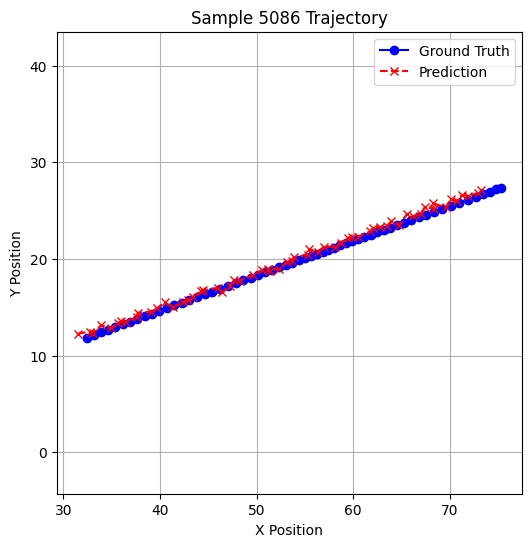

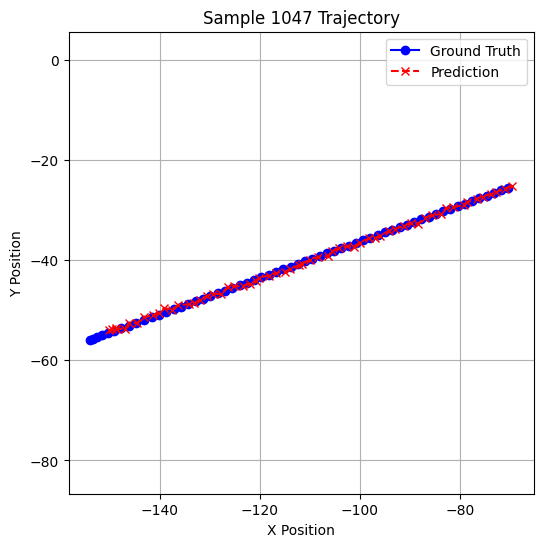

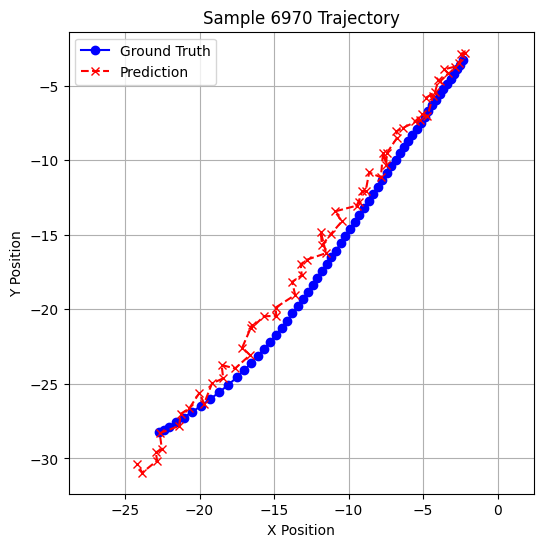

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# extract specific features
train_sample = train_y[sample_indices]

# Assume:
assert pred_y.shape == train_sample.shape

for i in range(pred_y.shape[0]):
    x_pred = pred_y[i, :, 0]
    y_pred = pred_y[i, :, 1]
    x_gt = train_sample[i, :, 0]
    y_gt = train_sample[i, :, 1]
    
    plt.figure(figsize=(6, 6))
    plt.plot(x_gt, y_gt, label='Ground Truth', color='blue', marker='o')
    plt.plot(x_pred, y_pred, label='Prediction', color='red', linestyle='--', marker='x')
    
    plt.title(f"Sample {sample_indices[i]} Trajectory")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()
